# Задача регрессии "Детские коляски б/у"
## Предсказываем стоимость колясок из объявлений на Авито
 <img src=https://img.c-inform.info/cache/5/4/23343423424.jpg/dw900h500.jpg width=800>


### 1. Описание проекта
Мы хотим научиться предсказывать цену на бывшую в употреблении детскую коляску, отталкиваясь от информации, представленной на Авито. 

### 2. Какой кейс решаем?
Исследовать, очистить, и преобразовать датасет, а затем построить модели, сделать предсказания и оценить их. 

**Что практикуем**

Визуализация, написание функций, методы очистки данных, базовые/продвинутые методы работы с библиотеками pandas, matplotlib, seaborn,
sklearn, оценка факторов, создание моделей машинного обучения для задачи регрессии, в том числе с помощью
кросс-валидации и подбора гиперпараметров, а так же построение прогнозов и метрик регрессии.

### 3. Краткая информация о данных
- Исходный датасет представляет из себя базу объявлений, выгруженную с Авито.

### 4. Этапы работы над проектом
- Исследование данных
- Очистка данных
- Разведывательный анализ(EDA)
- Преобразование данных
- Отбор признаков и стандартизация
- Построение моделей и прогнозов
- Выводы

Импортируем библиотеки

In [655]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce 
from sklearn.model_selection import cross_validate
import plotly.express as px
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from scipy.stats import shapiro
from scipy import stats

 # Исследование данных

Посмотрим на данные и пропуски. Оценим значимость признаков, которые у нас есть, в первом приближении.

In [656]:
df = pd.read_excel('22.xlsx')
df.head(3)

,Продавец,Контактное лицо,Тип продавца,Пол продавца,Заголовок,Описание,Цена,Регион,Город,Метро,...,Продвижение,Доставка,Снижение цены,"Снижение цены на, руб.","Снижение цены на, %",Вид товара,Состояние,Бренд,Цвет,Тип
0,Пользователь,NaN,Частное лицо,Не определено,Коляска zippy 2 в 1,Коляска очень в хорошем состоянии практически ...,15000,Московская область,Дзержинский,м. д. Дроздово,...,x15 на 1 день,0,0,NaN,NaN,Детские коляски,Б/у,Oyster,Синий,Универсальная (2 в 1)
1,Пользователь,NaN,Частное лицо,Не определено,Коляска Hartan racer gt,"Шикарная коляска, легко и мягко едет, удобная,...",8000,Московская область,Подольск,м. Подольск,...,NaN,0,0,NaN,NaN,Детские коляски,Б/у,Hartan,Белый,Прогулочная
2,Пользователь,NaN,Частное лицо,Не определено,Коляска прогулочная Oyster Zero,Продаю коляску Oyster zero зелёного цвета.В ко...,9700,Москва,Москва,м. Москва,...,NaN,0,0,NaN,NaN,Детские коляски,Б/у,Oyster,Зелёный,Прогулочная


In [657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421 entries, 0 to 3420
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Продавец                          3421 non-null   object 
 1   Контактное лицо                   431 non-null    object 
 2   Тип продавца                      3421 non-null   object 
 3   Пол продавца                      3421 non-null   object 
 4   Заголовок                         3421 non-null   object 
 5   Описание                          3421 non-null   object 
 6   Цена                              3421 non-null   int64  
 7   Регион                            3421 non-null   object 
 8   Город                             3421 non-null   object 
 9   Метро                             3421 non-null   object 
 10  Метро2                            2637 non-null   object 
 11  Метро. Время                      2637 non-null   object 
 12  Район 

In [658]:
df.shape

(3421, 50)

У нас есть 50 столбцов числового типа  и типа object. Есть два строковых признака Заголовок и Описание, которые содержат огромное количество информации, которую попытаемся трансформировать в подходящий для целей машинного обучения вид. Так же есть признаки бренда и типа коляски. Есть дата, географические признаки, с которыми поработаем тоже. И есть огромное количество пустых для нашей работы категориальных признаков, например "Номер объявления" или ссылки. Начнем.

In [659]:
# переведем признак даты в формат даты
df['Дата объявления'] = pd.to_datetime(df['Дата объявления'])
df['Дата объявления'].describe()

count                    3421
unique                   3385
top       2022-10-10 20:49:24
freq                        5
first     2022-05-28 22:49:20
last      2022-11-02 21:41:00
Name: Дата объявления, dtype: object

Видим, что данные собраны с 28 мая 2022 года по 2 ноября 2022 года.

## Дубли

In [660]:
# Проверим на дубли и избавимся от них, если они есть
all_columns = list(df.columns) 
df_duplicates = df[df.duplicated(subset=all_columns)]
print(f'Number of duplicates: {df_duplicates.shape[0]}')
df.drop_duplicates(inplace=True, ignore_index=True) 

Number of duplicates: 0


Дублей нет, посмотрим на долю пропусков:

# Очистка данных

In [661]:
df.isnull().mean().sort_values(ascending=False)

Снижение цены на, %                 1.000000
Снижение цены на, руб.              1.000000
Продвижение                         0.989769
Район                               0.986846
Контактное лицо                     0.874013
Сегодня просмотров                  0.460684
Продавец. Продажи с доставкой       0.354867
Цвет                                0.315989
Тип                                 0.304297
Бренд                               0.251388
Метро2                              0.229173
Метро. Время                        0.229173
Продавец. Регистрация               0.068986
Состояние                           0.001169
Параметры                           0.000877
Вид товара                          0.000877
Продавец. Рейтинг                   0.000585
Всего просмотров                    0.000292
Доставка                            0.000000
Продавец. Активные объявления       0.000000
Поднято                             0.000000
Выделено                            0.000000
VIP       

Удалим неинформативные для нас столбцы, а так же столбцы, дублирущие информацию друг друга, и еще удалим столбцы, в которых пропусков больше 35%.

In [662]:
df = df.drop(columns = [
    'Район', 'Контактное лицо', 'Сегодня просмотров', 'Метро. Время', 'Снижение цены на, %', 'Продавец. Продажи с доставкой', 'Категория',
     'Снижение цены на, руб.', 'Продвижение', 'Продавец', 'Пол продавца', 'Подкатегория', 'Регион', 'Ссылка на объявление', 'Можно написать сообщение',
     'Ссылки на картинки', 'Номер объявления', 'Адрес', 'XL', 'Параметры', 'Всего просмотров', 'Продавец. Ссылка', 'Продавец. Регистрация',
     'Вид товара', 'Продавец. Активные объявления','Продавец. Завершенные объявления', "Доставка", 'Широта', 'Долгота', 'Продавец. Рейтинг', 'Продавец. Кол-во отзывов',
     'Выделено', 'Снижение цены',], axis = 1)

Есть признаки, которые выглядят подозрительно идентичными: это "Продавец.Магазин" и "Продавец.Компания". Проверим:

In [663]:
print(df['Продавец. Компания'] == df['Продавец. Магазин'])
print('')
print(df['Продавец. Компания'].value_counts() == df['Продавец. Магазин'].value_counts())

0       True
1       True
2       True
3       True
4       True
        ... 
3416    True
3417    True
3418    True
3419    True
3420    True
Length: 3421, dtype: bool

Нет    True
Да     True
dtype: bool


Они идентичны

In [664]:
# удалим один из них
df = df.drop('Продавец. Компания', axis = 1)

Рассмотрим столбцы "Метро" и "Метро2", тк по названию они дублируют друг друга.

In [665]:
df[['Метро', 'Метро2']]


,Метро,Метро2
0,м. д. Дроздово,Красногвардейская
1,м. Подольск,NaN
2,м. Москва,Бунинская аллея
3,м. Москва,Шипиловская
4,м. Москва,Кантемировская
...,...,...
3416,м. Москва,Ясенево
3417,м. Москва,Ростокино
3418,м. Москва,Проспект Вернадского
3419,м. Москва,NaN


Видим, что значения отличаются, еще посмотрим на них:


In [666]:
df['Метро'].value_counts()

м. Москва                2354
м. Балашиха                74
м. Химки                   66
м. Мытищи                  49
м. Одинцово                44
                         ... 
м. Дедовск                  1
м. д. Коргашино             1
м. пос. Воскресенское       1
м. Кокошкино                1
м. д. Настасьино            1
Name: Метро, Length: 248, dtype: int64

In [667]:
df['Метро2'].value_counts()

Электрозаводская       166
Алтуфьево               71
Новокосино              56
Медведково              51
Планерная               49
                      ... 
Александровский сад      1
Новокузнецкая            1
Чкаловская               1
Окружная                 1
Лужники                  1
Name: Метро2, Length: 229, dtype: int64

Признак "Метро2" больше похож на правду, тк соответствует названиям метро г. Москвы. А признак "Метро" удалим.

In [668]:
df = df.drop('Метро', axis=1) 

In [669]:
# Еще раз глянем на пропуски в долях:
df.isnull().mean().sort_values(ascending=False).round(3)

Цвет                 0.316
Тип                  0.304
Бренд                0.251
Метро2               0.229
Состояние            0.001
Тип продавца         0.000
Заголовок            0.000
Описание             0.000
Цена                 0.000
Город                0.000
Дата объявления      0.000
Продавец. Магазин    0.000
Премиум              0.000
VIP                  0.000
Поднято              0.000
dtype: float64

In [670]:
# Посмотрим на пропуски в признаке "Состояние"
df[df['Состояние'].isnull() == True].shape[0]

4

In [671]:
# Здесь мы видим всего одну строку с пропусками, удалим ее:
df = df[df['Состояние'].isnull() == False]

Признак "Метро2" имеет 23% пропусков. Однако, все же пока не будем удалять эти данные, тк не во всех районах есть метро и строки с пропусками в этом признаке вполне возможны. Заменим пока пустые значения в этом признаке на "нет метро". 

In [672]:
df['Метро2'][df['Метро2'].isnull() == True] = 'нет метро'
df[df['Метро2'].isnull() == True].shape[0]

0

In [673]:
# Теперь попробуем разобраться с признаком "Бренд"
df['Бренд'].value_counts()

Hartan            994
Babyzen           344
Britax            331
Oyster            214
BRITAX ROEMER     192
Mamas&Papas       143
Thule             109
Bugaboo            31
YOYA               29
Recaro             15
Другой             14
Leclerc            13
Baby Jogger        11
Cybex              10
Valco baby          9
Maclaren            8
X-LANDER            7
Stokke              7
Peg-Perego          6
Danki               5
Yoya Plus           5
Silver Cross        5
Anex                4
Joie                4
Teutonia            3
Fd-Design           3
Adamex              3
Chicco              3
Maxi-Cosi           2
Mr Sandman          2
Esspero             2
Mountain Buggy      2
Camarelo            2
Carrello            2
Noordline           2
BABY                2
CAM                 2
EASYWALKER          1
Jane                1
Bubago              1
Elodie Details      1
Gesslein            1
Capella             1
Bloom               1
Babylux             1
TIZO      

Выше мы выяснили, что в признаке есть 25% пропусков. Данных у нас немного, попробуем поработать с ним позже. А пока просто заполним пропуски значением "no brand". И значение "другой" так же заменим на 'no brand'

In [674]:
df['Бренд'][df['Бренд'].isnull() == True] = 'no brand'
df['Бренд'][df['Бренд'] == "Другой"] = 'no brand'
df[df['Бренд'].isnull() == True].shape[0]

0

Аналогичные действия проделаем с признаками "Тип" и "Цвет"

In [675]:
df['Тип'].value_counts()

Прогулочная              906
Универсальная (2 в 1)    811
Аксессуары и запчасти    278
Люлька                   119
Универсальная (3 в 1)     99
Другой                    69
Трансформер               49
Трость                    33
Сумка-переноска           12
Велосипед-коляска          4
Name: Тип, dtype: int64

In [676]:
df['Тип'][df['Тип'].isnull() == True] = 'Другой'
df[df['Тип'].isnull() == True].shape[0]

0

In [677]:
df['Цвет'][df['Цвет'].isnull() == True] = 'Неизвестен'
df[df['Цвет'].isnull() == True].shape[0]

0

In [678]:
# убедимся, что теперь везде нули
df.isnull().mean().sort_values(ascending=False).round(3)

Тип продавца         0.0
Заголовок            0.0
Описание             0.0
Цена                 0.0
Город                0.0
Метро2               0.0
Дата объявления      0.0
Продавец. Магазин    0.0
Премиум              0.0
VIP                  0.0
Поднято              0.0
Состояние            0.0
Бренд                0.0
Цвет                 0.0
Тип                  0.0
dtype: float64

In [679]:
# глянем на датасет еще раз
df.describe()

,Цена,Премиум,VIP,Поднято
count,3417.000000,3417.0,3417.0,3417.0
mean,16172.899912,0.0,0.0,0.0
std,18136.779194,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0
25%,4000.000000,0.0,0.0,0.0
50%,10000.000000,0.0,0.0,0.0
75%,20999.000000,0.0,0.0,0.0
max,150000.000000,0.0,0.0,0.0


In [680]:
df.describe(include = 'object')

,Тип продавца,Заголовок,Описание,Город,Метро2,Продавец. Магазин,Состояние,Бренд,Цвет,Тип
count,3417,3417,3417,3417,3417,3417,3417,3417,3417,3417
unique,3,2461,3368,111,230,2,2,58,17,10
top,Частное лицо,Коляска,В комплекте:- чехол-переноска для коляски- дож...,Москва,нет метро,Нет,Б/у,Hartan,Неизвестен,Другой
freq,2825,118,10,2381,783,3181,2805,994,1077,1106


Видим, что в столбцах VIP, Премиум, Поднято стоят нули, удалим эти столбцы тоже, как не несущие никакой информации. 

In [681]:
df = df.drop(columns = ['VIP', 'Поднято', 'Премиум'], axis = 1)

Еще хотелось бы сразу исключить коляски, которые предлагаются не для продажи, а на прокат. Создадим столбец - индекс проката.


In [ ]:
df['Заголовок'] = df['Заголовок'].str.lower()
# Ключевые слова для прокатных колясок
keywords = [ "прокат", "проката", "аренда", "в аренду", 'аренды', 'арендовать', 'временное пользование' , 'тест драйв', "тест-драйв"]
df['Прокат'] = ''
# напишем функцию для изменения столбца "Прокат"
def change_type(row):
    if any(keyword in row['Заголовок'] for keyword in keywords):
        return 'прокат'
    else:
        return 'не прокат'

# Применение функции к столбцу "Прокат"
df['Прокат'] = df.apply(change_type, axis=1)
# выведем, сколько у нас таких значений получилось
print(df['Прокат'].value_counts())
# и посмотрим на эти строки в заголовках
df[df['Прокат'] == 'прокат']['Заголовок'].values


Похоже на правду, и нам они действительно не нужны, удалим их.

In [683]:
# удалим прокатные предложения
df = df[df['Прокат'] != 'прокат']

Теперь нам нужно проверить, убрали ли мы все прокатные предложения. Создадим аналогичную функцию для признака с описанием и применим ее к столбцу "Прокат"

In [684]:
def change_type(row):
    if any(keyword in row['Описание'] for keyword in keywords):
        return 'прокат'
    else:
        return 'не прокат'

# Применение функции к столбцу "Прокат"
df['Прокат'] = df.apply(change_type, axis=1)
# выведем, сколько у нас таких значений получилось
print(df['Прокат'].value_counts())

не прокат    3320
прокат         25
Name: Прокат, dtype: int64


Вот еще 25 строк нашлись, посмотрим на них поближе

In [685]:
#  посмотрим на эти строки 
df[df['Прокат'] == 'прокат'][['Описание', "Цена"]]

,Описание,Цена
140,Продаётся всё вместе: коляска britax В-Моtiоn ...,24000
202,Продажа и тест-драйв бу и новых колясок Mamas ...,17500
205,Продажа и тест-драйв бу и новых колясок Britax...,15745
206,Продажа и тест-драйв бу и новых колясок Britax...,4490
207,Продажа и тест-драйв бу и новых колясок Oyster...,4724
208,Продажа и тест-драйв бу и новых колясок Thule ...,55960
210,Продажа и тест-драйв бу и новых колясок Oyster...,25990
211,Продажа и тест-драйв бу и новых колясок Oyster...,25990
212,Тест-драйв (аренда) без залога: 950 руб. /1 не...,950
213,Продажа и тест-драйв бу и новых колясок Mamas ...,17500


Из 25 строк есть несколько реальных предложений о продаже, в которых в описании просто предлагают что-то взять еще к данной коляске в прокат, но коляску по факту продают. Остальное все нам не нужно. Переименуем полезные строки, а неполезные в данном контексте удалим.

In [686]:
# поменяем статус у менее подозрительных предложений
df['Прокат'].loc[[2864,1798,610,495, 140]] = 'не прокат'
# и еще раз удалим прокатные предложения
df = df[df['Прокат'] != 'прокат']
# и удалим признак "Прокат"
df = df.drop('Прокат', axis = 1)

Рассмотрим признак "Тип"

In [687]:
df['Тип'].value_counts()

Другой                   1040
Прогулочная               892
Универсальная (2 в 1)     804
Аксессуары и запчасти     277
Люлька                    117
Универсальная (3 в 1)      98
Трансформер                48
Трость                     33
Сумка-переноска            12
Велосипед-коляска           4
Name: Тип, dtype: int64

Видим, что есть акссесуары и запчасти, удалим их.

In [688]:
df = df[df['Тип'] != 'Аксессуары и запчасти']

## Выбросы

In [689]:
df.describe()

,Цена
count,3048.000000
mean,17458.818898
std,18452.906421
min,0.000000
25%,5000.000000
50%,11990.000000
75%,23000.000000
max,150000.000000


Исследуем на выбросы признак цены.
### Цена

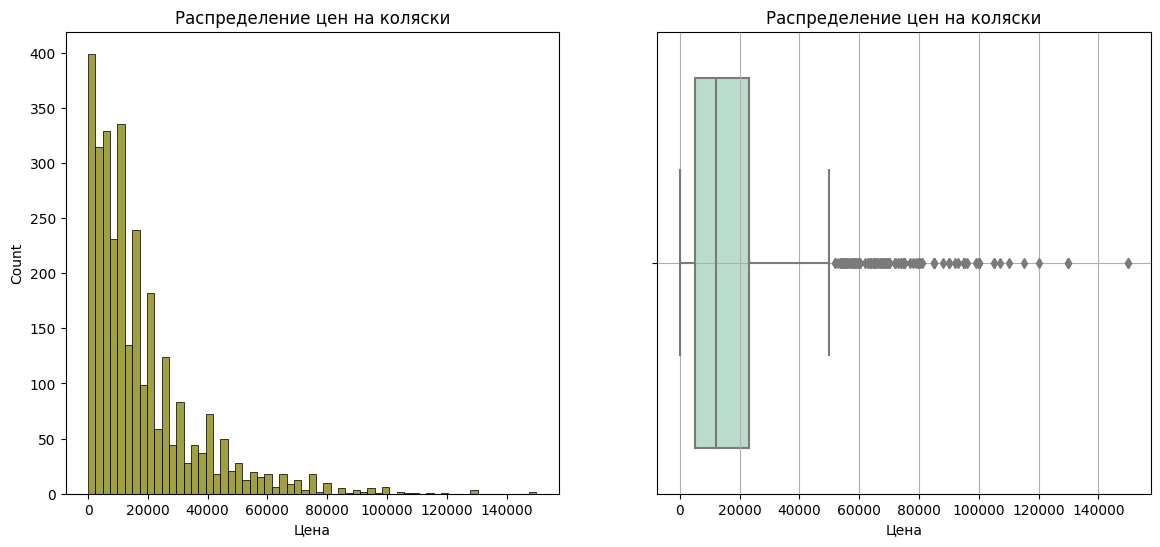

In [690]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
#строим гистограмму
sns.histplot(data=df, x='Цена',color='olive', ax=axes[0])
# строим boxplot 
sns.boxplot(data=df, x='Цена', palette='Pastel2', ax=axes[1]) 
#задаём названия графикам
axes[0].set_title('Распределение цен на коляски')
axes[1].set_title('Распределение цен на коляски')
plt.grid()

In [691]:
# Посмотрим на данные о колясках стоимостью более 100000:
df[df['Цена'] > 100000].sort_values('Цена', ascending = False)

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип
1850,Частное лицо,коляска 2 в 1,Детская коляска Hartan Mercedes Avant-garde,150000,Москва,Кузьминки,2022-10-18 18:11:02,Нет,Новый,Hartan,Неизвестен,Другой
2808,Частное лицо,"коляска 3 в 1, коляска hartan, прогулочная кол...",Детская коляска 3 в 1 Hartan VIP из лимитирова...,149990,Москва,Кунцевская,2022-10-09 21:52:12,Нет,Б/у,Hartan,Чёрный,Универсальная (3 в 1)
512,Частное лицо,новая детская коляска 2 в 1 hartan amg gt merc...,"Коляски новые, в заводской упаковке, с гаранти...",130000,Москва,Андроновка,2022-10-30 10:37:02,Нет,Новый,Hartan,Чёрный,Универсальная (2 в 1)
1462,Частное лицо,коляска 2 в 1 hartan mercedes,Универсальная коляска Hartan Avantgarde Merced...,130000,Москва,Крылатское,2022-10-21 22:06:49,Нет,Б/у,Hartan,Красный,Универсальная (2 в 1)
1980,Частное лицо,коляска для двойни kartan,Коляска для двойни цвет темно синий очень удоб...,130000,Черное,нет метро,2022-10-17 17:27:33,Нет,Б/у,Hartan,Синий,Универсальная (2 в 1)
2904,Частное лицо,коляска hartan amg gt 2в1,Детская коляска Hartan AMG GT 230 Silver (с су...,120000,Москва,Университет,2022-10-08 20:31:13,Нет,Б/у,Hartan,Серебряный,Универсальная (2 в 1)
3407,Магазин,bugaboo donkey 5 коляска 2 в 1 новая,абсолютно новая коляска в коробке-отличный под...,115000,Москва,Алтуфьево,2022-10-03 11:16:28,Да,Б/у,no brand,Неизвестен,Другой
2903,Частное лицо,коляска,Коляска Hartan mersedes-Benz. Как новая. Польз...,110000,Москва,Царицыно,2022-10-08 20:37:36,Нет,Б/у,Hartan,Бежевый,Универсальная (2 в 1)
2013,Частное лицо,коляска 2 в 1 hartan amg gt,Состояние идеальное. Модель 2021 года! Произво...,107000,Москва,Братиславская,2022-10-17 12:05:54,Нет,Б/у,Hartan,Серый,Универсальная (2 в 1)
510,Частное лицо,новая коляска hartan mercedes avantgarde,"Все коляски новые, в заводской упаковке с гара...",105000,Москва,Андроновка,2022-10-30 10:44:00,Нет,Новый,Hartan,Красный,Универсальная (2 в 1)


Видим, что все строки соответствуют бренду Hartan, который является премиальным в колясках и эти модели действительно могут столько стоить. Посмотрим на распределение цены для этого бренда, а так же обратим внимание на состояние.

Text(0.5, 1.0, 'Распределение цены на коляски Hartan')

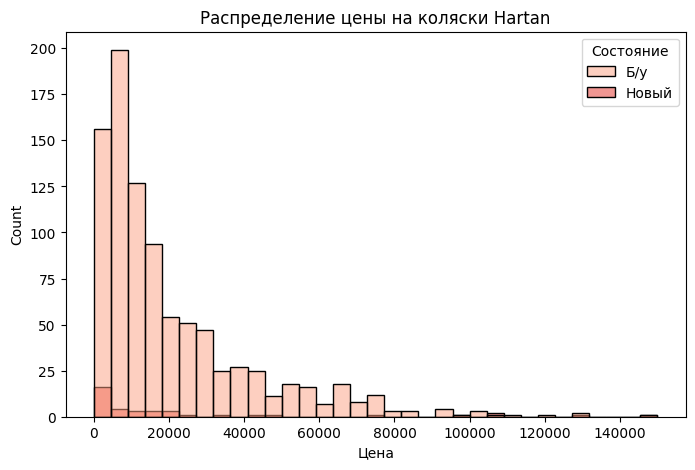

In [692]:
# задаем плоскость
fig, ax = plt.subplots(figsize=(8, 5))
# строим гистограмму
ax = sns.histplot(data = df[df['Бренд']== 'Hartan'], x ='Цена', hue = 'Состояние', ax = ax, palette= 'Reds')
#задаём названия графикам
ax.set_title('Распределение цены на коляски Hartan')

Видим, что почему-то большинство данных, относящихся к этому бренду стоят до 20000 рублей и некоторая часть из них даже указаны как новые! При этом ранее так же было замечено, что несколько колясок дороже 100000 являются б/у. Это выглядит противоречиво, посмотрим на строки со стоимостью меньше 5000 рублей бренда Hartan и состоянием "Новый":

In [693]:
df[(df['Бренд']== 'Hartan')&(df['Цена']<5000)&(df['Состояние']== 'Новый')].head(10)

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип
20,Частное лицо,сумка для коляски hartan хартан s.oliver,Сумка для коляски Hartan Хартан.Коллекция S.Ol...,990,Москва,Жулебино,2022-11-02 18:27:28,Нет,Новый,Hartan,Серый,Другой
261,Частное лицо,адаптер для коляски hartan,Адаптер для автокресел Britax Roemer ( Baby-Sa...,3500,Москва,Жулебино,2022-10-31 23:54:57,Нет,Новый,Hartan,Чёрный,Люлька
309,Частное лицо,колесо для коляски hartand buggy,Колесо новое,500,Москва,Улица академика Янгеля,2022-10-31 18:30:33,Нет,Новый,Hartan,Неизвестен,Другой
432,Частное лицо,чехлы на колеса коляски,"Новые, диаметр 30 + см",500,Москва,Октябрьское поле,2022-10-30 21:33:18,Нет,Новый,Hartan,Чёрный,Другой
475,Частное лицо,запчасти и аксессуары hartan списком,Цена в объявлении ОТ.Новые аксессуары и запчас...,900,Москва,Ленинский проспект,2022-10-30 14:52:53,Нет,Новый,Hartan,Неизвестен,Другой
911,Частное лицо,сетка москитнаяhartan (оригинал) без козырька,"Новая москитная сетка Hartan, без козырька, та...",2500,Москва,Площадь революции,2022-10-26 21:02:35,Нет,Новый,Hartan,Неизвестен,Другой
961,Частное лицо,чехлы на колёса коляски hartan,Продаю новые чехлы на колёса фирмы Hartan. Пок...,600,Химки,нет метро,2022-10-26 14:13:30,Нет,Новый,Hartan,Чёрный,Другой
962,Частное лицо,"матрас в коляску, люльку любой модели hartan",Мягкий и эластичный матрас Softline-Klima® обе...,500,Химки,нет метро,2022-10-26 14:13:25,Нет,Новый,Hartan,Белый,Другой
1380,Частное лицо,люлька для коляски hartan,Люлька для коляски Hartan Topline.Купили как с...,2000,Москва,Отрадное,2022-10-22 20:33:35,Нет,Новый,Hartan,Бежевый,Другой
1451,Частное лицо,коляска hartan удлинитель спального места,Удлинитель спального места для hartan racer gt...,2300,Москва,Домодедовская,2022-10-22 01:47:52,Нет,Новый,Hartan,Белый,Универсальная (3 в 1)


Оказалось, что это не коляски, а запчасти и аксессуары к ним при том, что признак "Тип" нам не всегда об этом говорит. И есть так же данные о запчастях в других брендах. А ведь они нам не нужны, так как мы строим модель, которая будет предсказывать цены на коляски. Нам нужно избавиться от таких данных. Создадим новый признак "Коляска" следующим образом: если есть слово "коляска" с большой или маленькой буквы в признаке "Заголовок", впишем значением "коляска" в именительном падеже, а если нет (все падежи, кроме именительного, как зависимые слова в запчастях), то "аксессуары". 

In [694]:
df['Коляска'] = df['Заголовок'].apply(lambda x: 'Коляска' if ('Коляска' in x or 'коляска' in x) else 'Аксессуары' )
df['Коляска'].value_counts()

Коляска       2260
Аксессуары     788
Name: Коляска, dtype: int64

Итого, получили 788 строк, удалим их и сам стобец "Коляска":

In [695]:
df = df[df['Коляска'] == 'Коляска']
df = df.drop('Коляска', axis = 1)

Рассмотрим так же коляски, в которых после всех преобразований цена не больше 1000 рублей:

In [ ]:
df[df['Цена']<= 1000]

Вот эти строки с нулевой ценой и ценой до 1000 явно не дадут нам никакой пользы, скорее вред, так как могут сбить с толку модель. Посмотрим на описания с нулевыми ценами.

In [ ]:
df[df['Цена']== 0]['Описание'].values

Как и предполагалось после изучения всех этих описаний, что это просто какие-то предложения от магазинов без цен. Удалим их.

In [ ]:
df = df[df['Цена']>0]
# еще раз посмотрим на предложения не больше 1000 рублей
df[df['Цена']<= 1000]

из этих 14 оставшихся строк есть еще коляски на запчасти, коляска за сладости за 10 рублей и вариант для дачи, удалим все это.

In [699]:
df = df[df['Цена']>1000]

# Разведывательный анализ данных

Начнем со строк, в которых не указаны бренд, тип, или цвет и попробуем что-то с ними сделать.

In [700]:
print(f"количество строк, где бренд не указан - {df[df['Бренд']== 'no brand'].shape[0]}")
print(f"количество строк, где тип не указан - {df[df['Тип']== 'Другой'].shape[0]}")
print(f"количество строк, где цвет не указан - {df[df['Цвет']== 'Неизвестен'].shape[0]}")
# так же выведем пересечение всех этих значений
# создаем маску
mask = (df['Цвет'] == 'Неизвестен')&(df['Тип'] == 'Другой')&(df['Бренд'] == 'no brand')
# выводим количество строк и сами строки
print(f"количество строк, где не указаны ни цвет, ни тип, ни бренд - {df[mask].shape[0]}")

количество строк, где бренд не указан - 391
количество строк, где тип не указан - 526
количество строк, где цвет не указан - 504
количество строк, где не указаны ни цвет, ни тип, ни бренд - 310


Замечаем, что в этих строках в признаке "Заголовок" все же указан бренд, а в описании есть какие-то подобия типа (и, может, цвета). Видимо, многие люди не очень склонны заполнять объявления по указанной форме, пропуская некоторые важные (для нас) поля, но многие включают эту информацию в заголовки и описания. Начнем с признака "Тип".

### Тип

In [701]:
df['Тип'].value_counts()

Прогулочная              794
Универсальная (2 в 1)    704
Другой                   526
Универсальная (3 в 1)     82
Трансформер               40
Трость                    25
Люлька                    24
Сумка-переноска            1
Name: Тип, dtype: int64

У нас есть группа значений, которые были пропусками и мы заполнили их значением "Другой". После всех дальнейших преобразований мы еще вернемся к нему,  а пока для удобства переименуем некоторые значения, так как очень скоро они понадобятся.

In [702]:
df.loc[df['Тип'] == 'Универсальная (2 в 1)', 'Тип'] = '2 in 1'
df.loc[df['Тип'] == 'Универсальная (3 в 1)', 'Тип'] = '3 in 1'
df['Тип'].value_counts()

Прогулочная        794
2 in 1             704
Другой             526
3 in 1              82
Трансформер         40
Трость              25
Люлька              24
Сумка-переноска      1
Name: Тип, dtype: int64

### БРЕНД И МОДЕЛЬ

Попробуем разбить работу с этим признаком на две части: 
- 1.  Достать из заголовков названия брендов. После некоторого изучения описаний и заголовков выявилось, что многие публикации содержат написание брендов в произвольном варианте, например mamas&papas пишут как mamas and papas или mamas papas, а hartan пишут хартан. Учтем это.
- 2. Создать более точный признак - модель коляски. В рамках одного бренда есть разные ценовые диапазоны даже для новых колясок, так как важна еще модель. Попробуем вытащить из описания и названия брендов, и модели.

### Бренд

In [703]:
print(f' Количество брендов: {df["Бренд"].nunique()}')
df['Бренд'].value_counts() # посмотрим на исходные данные

 Количество брендов: 50


Hartan            767
no brand          391
Britax            247
Oyster            190
Babyzen           163
BRITAX ROEMER     159
Mamas&Papas        90
Thule              60
Bugaboo            14
YOYA               13
Recaro             12
Baby Jogger         9
Leclerc             8
Danki               5
X-LANDER            5
Maclaren            5
Joie                4
Cybex               4
Silver Cross        4
Peg-Perego          4
Stokke              3
Adamex              3
Yoya Plus           3
Maxi-Cosi           2
CAM                 2
Noordline           2
Mountain Buggy      2
Teutonia            2
Esspero             2
Fd-Design           1
Babylux             1
Capella             1
Camarelo            1
Bubago              1
Gesslein            1
Mr Sandman          1
Bloom               1
Cosatto             1
Moon                1
RYAN                1
Verdi               1
Valco baby          1
Squizz Looping      1
Mima                1
Hauck               1
Tutis     

Изначально имеем 49 определнных брендов + 1 "no brand"

In [704]:
# приведем все значения в столбцах для работы к нижнему регистру для удобства
df['Описание'] = df['Описание'].str.lower()
df['Заголовок'] = df['Заголовок'].str.lower()
df['Бренд'] = df['Бренд'].str.lower()
# создаем список брендов и удалим из него значение 'no brand' 
brand_list = list(set(df['Бренд']))
brand_list.remove('no brand')
# удалим значение 'baby', так как такого бренда не существует и мы заменим его на название из заголовка
brand_list.remove('baby')
# создадим еще список,в котором будут значения, соответствующие брендам и их вариантам написания, так же указанные в заголовке 
add_br = ['mamas papas', 'mamas and papas', 'mamas & papas', 'хартан', 'espiro', 'uppababy', 'yoyo', 'yoyo+', 'yoyo2',
          'xiaomi', 'combi', 'Phil & Teds', 'Phil and Teds', 'baby design', 'egg', 'xartan', 'hartman', 'carrello', 
          'mamaspapas', 'mamas@papas,solo 2.']
# соединим списки
brand_list.extend(add_br)

In [705]:
#  заменим значение в признаке "Бренд" на значение из признака "Заголовок" или "Описание", если он есть в соответствующей строке
def replace_brand(row):
    for word in brand_list:
        if word in row['Заголовок'] or word in row['Описание']:
            return word
    return row['Бренд']

# Применение функции к столбцу "Бренд"
df['Бренд'] = df.apply(replace_brand, axis=1)

Было замечено, что в описаниях люди иногда сравнивают свою коляску с каким-то другим более дорогим брендом, что может привести к неверному заполнению столбца "Бренд". Однако мы не можем убрать признак описания из цикла выше, так как часть данных есть только там. Поэтому еще раз создадим аналогичную функцию, пройдя только по заголовкам, так как их значения первичны и если где-то есть строки, где в заголовке указан бренд, а в описании есть сравнение с другим брендом, то мы возьмем бренд из заголовка наверняка.

In [706]:
def replace_brand_final(row):
    for word in brand_list:
        if word in row['Заголовок']:
            return word
    return row['Бренд']

# Применение функции к столбцу "Бренд"
df['Бренд'] = df.apply(replace_brand_final, axis=1)

Теперь осталось объединить одинаковые бренды, написанные по-разному:

In [707]:
# объединяем по смыслу значения
df['Бренд'] = df['Бренд'].apply(lambda x: 'mamas and papas' \
    if x == 'mamas papas' or x == 'mamas&papas' or x == 'mamas & papas' or x == 'mamaspapas' or x== 'mamas@papas,solo 2.' \
    else 'hartan' if x == 'хартан' or x == 'xartan' or x == 'hartman' \
    else 'babyzen yoyo' if x == 'yoyo' \
    else 'yoya' if x == 'yoya plus' \
    else 'britax' if x == 'britax roemer' \
    else x )

In [708]:
# проверим, что строк без бренда не осталось
df[df['Бренд']== 'no brand']

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип


In [709]:
# проверим, что объединили все значения
df['Бренд'].value_counts()

hartan             946
britax             457
babyzen            251
oyster             211
mamas and papas    109
thule               79
baby jogger         15
bugaboo             13
danki               11
yoya                 9
leclerc              8
stokke               7
cybex                6
babyzen yoyo         6
recaro               5
maclaren             5
teutonia             4
silver cross         4
baby design          4
mr sandman           3
carrello             3
mountain buggy       3
adamex               3
x-lander             3
espiro               2
esspero              2
ryan                 2
egg                  2
anex                 2
cam                  2
bloom                1
maxi-cosi            1
capella              1
cosatto              1
gesslein             1
peg-perego           1
xiaomi               1
verdi                1
inglesina            1
mima                 1
joie                 1
noordline            1
valco baby           1
hauck      

Итого, вместо 391 отсутствующих брендов их стало 0. Плюс мы убрали непонятное значение baby и переименовали эти строки в соответствии с заголовками и описаниями. Но для предсказания цены название бренда само по себе не слишком много дает, больше даст модель коляски в рамках каждого бренда.  И еще сразу создадим столбец цены новой коляски каждой модели, цены возьмем на сегодняшний день как ориентир (октябрь 2023).  Удалим так же строки, в которых встречаются самые редкие бренды, чье количество в датасете не превышает 20 единиц.

In [710]:
# составим список значений с частотой не меньше 20
value_counts = df['Бренд'].value_counts()
top_values = value_counts[value_counts > 20].index.tolist()
# Оставляем только строки, содержащие эти значения
df = df[df['Бренд'].isin(top_values)]
# проверим
df["Бренд"].value_counts()

hartan             946
britax             457
babyzen            251
oyster             211
mamas and papas    109
thule               79
Name: Бренд, dtype: int64

### Модель

Начнем по топ-списку количества моделей в рамках каждого бренда, больше всего у нас предложений Hartan. 

Создадим столбец "Модель" и "Цена новой", а так же список с моделями колясок hartan  и заполним соответствующие строки. 

In [711]:
#  создаем маску
mask1 = df['Бренд'] == 'hartan'
# создаем столбцы
df['Модель'] = 0
df['Цена новой'] = 0
hartan_list = ['hartan racer gt', 'hartan buggi ix1','hartan buggy ix1','hartan xperia', 'hartan mercedes',
               'hartan topline', 'hartan vip', 'hartan two select', 'hartan amg gt mercedes-benz', 'hartan bit','hartan racer gts', 'hartan zx ii',
               'hartan sky xl', 'hartan raser gt', 'hartan 2 в 1 racer gt', 'hartan top line x', 'avantgarde mercedes-benz',
               'r1 gts xl selection', '2 в 1', '2в1', '3в1', '3 в 1']
hartan_pricelist = [129000, 25000, 25000, 73000, 160000, 84000, 120000, 190000, 160000, 24000, 98000, 70000, 70000,
                 129000, 129000, 84000, 160000, 121000, 115000, 115000, 125000, 125000]

# создадим функцию, чтобы не повторять код 6 раз для всех брендов
# проходим по каждой строке датафрейма
def get_model(mask, mod_list, price_list):
    for index, row in df[mask].iterrows():
        description = row["Описание"]
        title = row["Заголовок"]
# Проверяем наличие слова X в описании или заголовке
        for word in mod_list:
            if word in description or word in title:
                model_index = mod_list.index(word)
                price = price_list[model_index]
# Заполняем столбцы "Модель" и "Цена новой"
                df.at[index, "Модель"] = word
                df.at[index, "Цена новой"] = price

# применим к бренду Hartan
get_model(mask1, hartan_list, hartan_pricelist)         
# проверим, сколько осталось незаполненных колясок Хартан
df[mask1&(df['Модель']==0)].shape[0]

143

In [712]:
df[mask1].groupby('Модель')['Цена новой'].mean().sort_values(ascending=False) # выведем модели и цены

Модель
hartan mercedes             160000.0
avantgarde mercedes-benz    160000.0
hartan racer gt             129000.0
hartan raser gt             129000.0
3 в 1                       125000.0
3в1                         125000.0
hartan vip                  120000.0
2в1                         115000.0
2 в 1                       115000.0
hartan racer gts             98000.0
hartan top line x            84000.0
hartan topline               84000.0
hartan xperia                73000.0
hartan zx ii                 70000.0
hartan buggy ix1             25000.0
hartan buggi ix1             25000.0
hartan bit                   24000.0
0                                0.0
Name: Цена новой, dtype: float64

In [713]:
# объединяем по смыслу значения
df['Модель'] = df['Модель'].apply(lambda x:
    'hartan mercedes' if x == 'avantgarde mercedes-benz'\
    else 'hartan racer gt' if x == 'hartan 2 в 1 racer gt' or x == 'hartan raser gt' \
    else 'hartan topline' if x == 'hartan top line x' \
    else 'hartan buggi ix1' if x == 'hartan buggy ix1' \
    else 'hartan 2 in 1' if x=='2 в 1' or x == '2в1' \
    else 'hartan 3 in 1' if x == '3 в 1' or x == '3в1' \
    else x )

А еще у нас есть строки, в которых одновременно значения столбца "Тип" = "2 in 1" и  бренд = "Hartan". При этом перебор выше не присвоил им никакую модель по поиску из опсаний и заголовков. У нас есть значение "hartan 2 in 1" для этой комбинации и стоимость коляски новой в таком случае составляет 115000. Заполним такие строки.

In [714]:
hartan_2_in_1_list = list(df[mask1&(df['Тип'] == "2 in 1")&(df['Модель'] == 0)].index)
df.loc[hartan_2_in_1_list, 'Модель'] = 'hartan 2 in 1'
df.loc[hartan_2_in_1_list, 'Цена новой'] = 115000
# проверим
df[mask&(df['Тип']== "2 in 1")&(df['Модель']==0)]

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип,Модель,Цена новой


In [715]:
# Теперь сделаем тоже самое для "hartan 3 in 1"
hartan_3_in_1_list = list(df[mask1&(df['Тип'] == "3 in 1")&(df['Модель'] == 0)].index)
df.loc[hartan_3_in_1_list, 'Модель'] = 'hartan 3 in 1'
df.loc[hartan_3_in_1_list, 'Цена новой'] = 125000

In [716]:
# проверим общую картину по бренду Hartan
df[mask1&(df['Модель']!=0)].groupby('Модель').agg({'Модель':'count', 'Цена новой':'mean', 'Цена': 'mean'}).rename(
        columns={'Модель': 'Количество', 'Цена': "Средняя цена из объявлений"}).reset_index().sort_values(by='Количество', ascending=False)

,Модель,Количество,Цена новой,Средняя цена из объявлений
0,hartan 2 in 1,541,115000.0,25955.088725
5,hartan racer gt,93,129000.0,16421.279570
8,hartan vip,77,120000.0,17679.207792
1,hartan 3 in 1,35,125000.0,23219.428571
7,hartan topline,34,84000.0,15490.823529
4,hartan mercedes,15,160000.0,62866.666667
2,hartan bit,14,24000.0,11113.571429
3,hartan buggi ix1,14,25000.0,7892.857143
6,hartan racer gts,12,98000.0,32000.000000
9,hartan xperia,11,73000.0,22136.363636


Построим сводную диаграмму с уровнем цен на новые коляски и средние цены на эти же модели в объявлениях. Напишем для этого функцию, чтобы потом пользоваться для визуализации по другим моделям. 

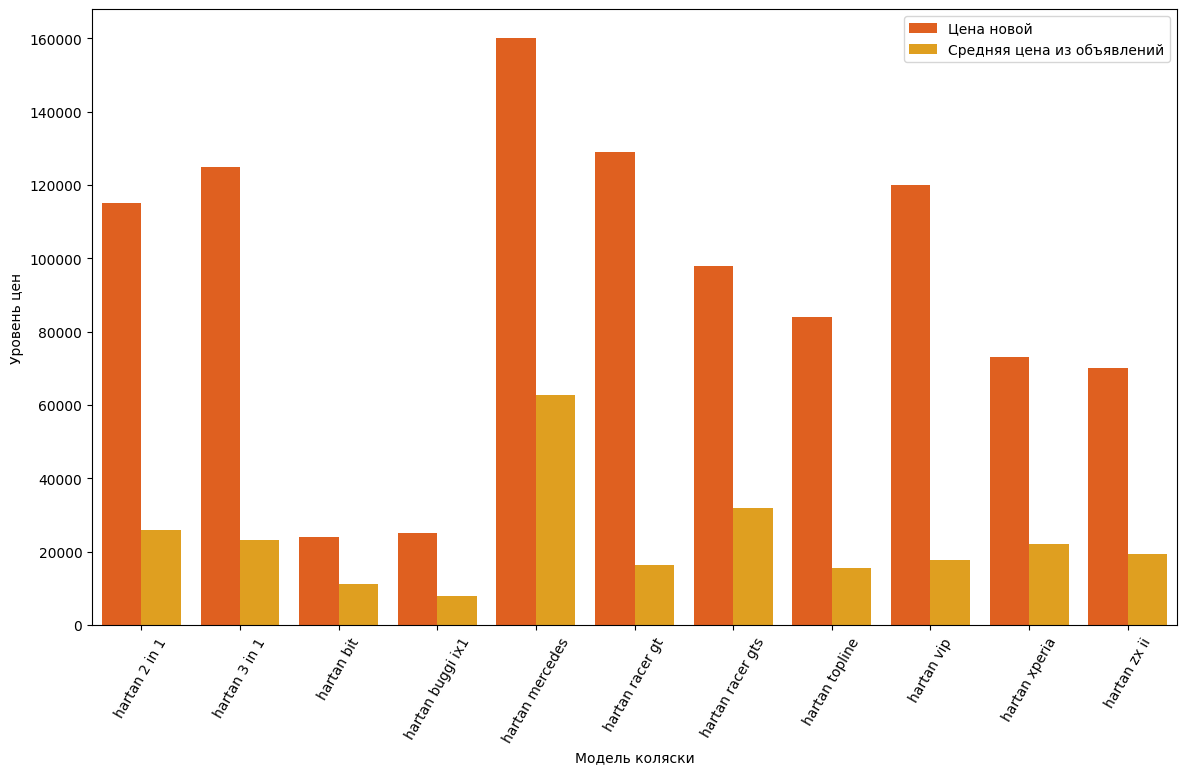

In [717]:
def model_vizual(mask, color):
    #  подготовим датасет
    piv = df[mask&(df['Модель']!=0)].groupby('Модель').agg({'Модель':'count', 'Цена новой':'mean', 'Цена': 'mean'}).rename(
        columns={'Модель': 'Количество', 'Цена': "Средняя цена из объявлений"}).reset_index().sort_values(by='Модель')
    piv = piv.drop('Количество', axis=1)
    piv = piv.set_index('Модель')
    df1 = piv.stack().reset_index(level=1)
    df1.columns = ['Цены на новые и цены на объявления', 'Цена']

    # строим график
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(x=df1.index.values, y='Цена', hue='Цены на новые и цены на объявления', data=df1, palette= color, ax = ax)
    ax.xaxis.set_tick_params(rotation=60)
    # Добавление подписей осей и легенды
    plt.xlabel('Модель коляски')
    plt.ylabel('Уровень цен')
    plt.legend()
   # Отображение графика
    plt.show()

model_vizual(mask1, 'autumn')

Видим, что отрыв между новой моделью и средней ценой на эту же модель из объявления довольно сильный и везде разный. Где-то в 2 раза, где-то в 3, а где-то гораздо больше. Очевидно, что есть другие факторы, например, важно еще и состояние коляски из объявления, его мы тоже попробуем выяывить, оценить и создать соответствующий признак позже.

Перейдем к следующему бренду по списку, это Britax. Создадим список моделей (в разном их написании из описания) и цен на новые, а потом заполним соответствующие столбцы.

In [718]:
mask2 = df['Бренд']== 'britax'
britax_list = ['smile 3','smile 3', 'III', 'smile iii', 'b-agile', 'b agile', 'smile 3',
               'b angle', 'b-lite', 'b motion 4','в-моtiоn 4', 'b-motion 4', 'b-motion 3', 
               'affinity', 'britex bi motion 3+', 'smile 2', 'britax b- motion',
               'smille 2', 'britax b motion', 'прогулочная']
britax_pricelist = [70000,70000, 70000, 70000, 20000, 20000, 70000, 20000, 19000, 30000, 30000, 30000, 25000, 35000, 
                     25000, 53000, 25000, 53000, 25000, 24000]

get_model(mask2, britax_list, britax_pricelist)            
df[mask2&(df['Модель']==0)].shape[0]

77

Осталось еще много неразмеченных моделей Britax. Попробуем еще  заполнить этот признак следующим образом: дополнительно отфильтруем неразмеченные модели колясок Britax по типу "Прогулочная", так мы избежим всех трансформеров и сочетаний "2 в 1" и "3 в 1". Цена на новую прогулочную коляску Britax около 24000. 

In [ ]:
df[mask2&(df['Модель']==0)&(df['Тип']== "Прогулочная")]

После изучения заголовков этой части датасета удалим несколько предложений, которые явно не соответствуют нашему фильтру: двойная, для погодок, audi, bob и тд, а остальным присвоим модель "Прогулочная" и цену новой 24000. 

In [720]:
df = df.drop([3366, 3028, 2082, 2047, 1705, 1461, 890, 813, 890, 2082, 773, 797, 1762, 719])
loc_list  = list(df[mask2&(df['Модель']==0)&(df['Тип']== "Прогулочная")].index)
df.loc[loc_list, 'Модель'] = 'britax прогулочная'
df.loc[loc_list, 'Цена новой'] = 24000

In [721]:
# проверим, сколько осталось незаполненных моделей колясок Britax
df[mask2&(df['Модель']==0)].shape[0]

45

Стало получше. 

In [722]:
# выведем модели и цены
df[mask2].groupby('Модель')['Цена новой'].mean().sort_values(ascending=False) 

Модель
smile iii              70000.0
smile 3                70000.0
smile 2                53000.0
smille 2               53000.0
affinity               35000.0
в-моtiоn 4             30000.0
b motion 4             30000.0
b-motion 4             30000.0
britax b motion        25000.0
b-motion 3             25000.0
britex bi motion 3+    25000.0
прогулочная            24000.0
britax прогулочная     24000.0
b-agile                20000.0
b angle                20000.0
b agile                20000.0
0                          0.0
Name: Цена новой, dtype: float64

In [723]:
# объединяем по смыслу значения
df['Модель'] = df['Модель'].apply(lambda x:
    'britax b-motion 4' if x == 'b motion 4'or x == 'в-моtiоn 4' or x == 'b-motion 4' \
    else 'britax b-motion 3' if x == 'britax b- motion' or x == 'britax b motion' or x == 'b-motion 3' or x == 'britex bi motion 3+' \
    else 'britax b-agile' if x == 'b-agile'  or x == 'b agile' or x == 'b angle' \
    else 'britax smile 3' if x== 'smile 3' or x == 'smile iii' \
    else 'britax smile 2' if x == 'smile 2' or x == 'smille 2' \
    else 'britax прогулочная' if x == 'прогулочная' \
    else 'britax b-smart' if x == 'b-smart' \
    else x )
# проверим
df[mask2&(df['Модель']!=0)].groupby('Модель').agg({'Модель':'count', 'Цена новой':'mean', 'Цена': 'mean'}).rename(
        columns={'Модель': 'Количество', 'Цена': "Средняя цена из объявлений"}).reset_index().sort_values(by='Количество', ascending=False)

,Модель,Количество,Цена новой,Средняя цена из объявлений
6,britax прогулочная,241,24000.0,12947.580913
1,britax b-agile,57,20000.0,10977.175439
2,britax b-motion 3,28,25000.0,14906.035714
4,britax smile 2,27,53000.0,23773.666667
5,britax smile 3,21,70000.0,40928.523810
3,britax b-motion 4,15,30000.0,16740.000000
0,affinity,11,35000.0,13536.272727


Визуализируем эту модель аналогично предыдущей.

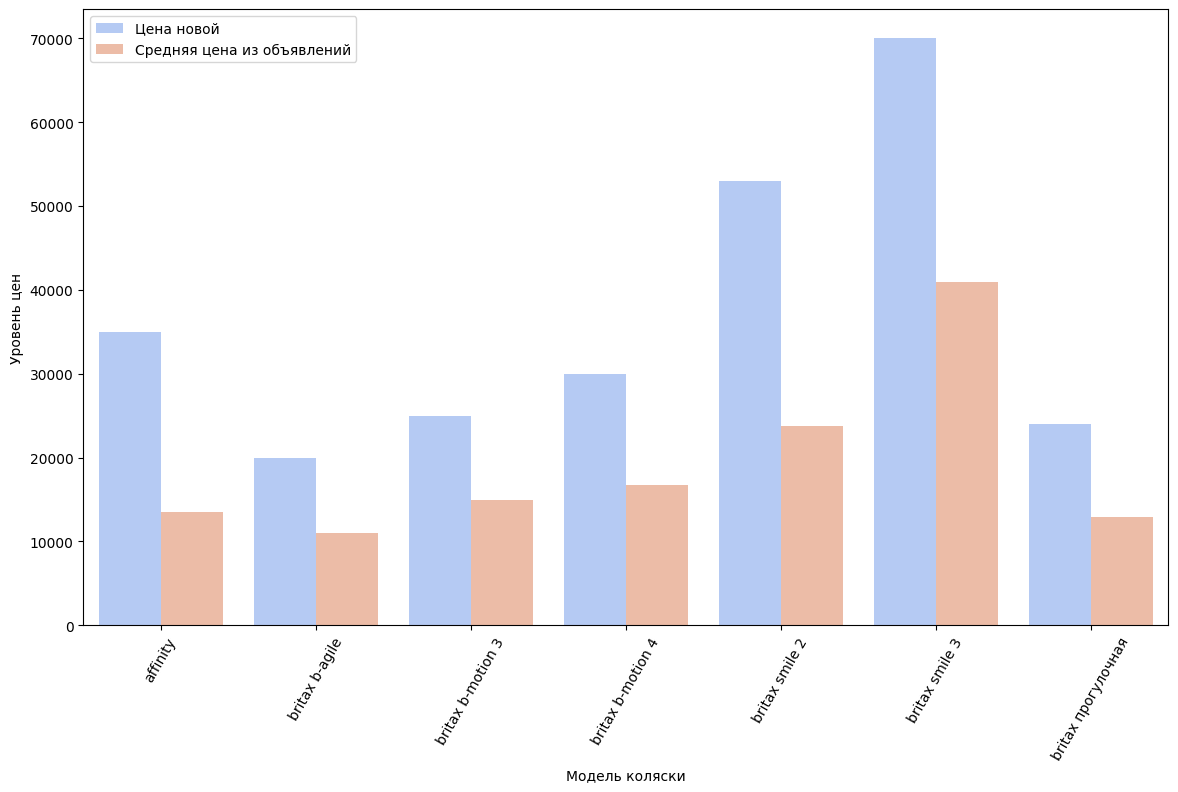

In [724]:
model_vizual(mask2 , 'coolwarm')

Становится похоже, что за полцены нового дорогого Hartan нет предложений (а это 60-70 тысяч), так как мало кто купит б/у с таким бюджетом, люди чаще выберут новые модели менее дорогого бренда, поэтому б/у предложения там сильно ниже по средней цене от стоимости новых колясок, иначе продать сложно. А здесь примерно за полцены от новой в среднем люди продают б/у коляски Britax. Но надо еще в будущем смотреть состояния.

Следующий бренд Babyzen

In [725]:
df[df['Бренд']== 'babyzen'].head()

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип,Модель,Цена новой
12,Частное лицо,коляска babyzen yoyo оригинал,"складывается одной рукой, колёса в хорошем сос...",20000,Москва,Рассказовка,2022-11-02 19:43:03,Нет,Б/у,babyzen,Красный,Прогулочная,0,0
31,Компания,коляска babyzen oyoy plus оригинал,в отличном состоянии! использовали очень мало....,18000,Москва,Ботанический сад,2022-11-02 16:24:34,Нет,Б/у,babyzen,Неизвестен,Другой,0,0
34,Частное лицо,коляска,"babyzen yoyo оригинальная!3 года катались, реб...",5000,Москва,Новаторская,2022-11-02 16:22:17,Нет,Б/у,babyzen,Розовый,Прогулочная,0,0
43,Частное лицо,новая коляска babyzen yoyo 2,новая коляска babyzen yoyo 2 с прогулочным бло...,43500,Москва,Саларьево,2022-11-02 14:13:56,Нет,Новый,babyzen,Неизвестен,Другой,0,0
55,Частное лицо,коляска babyzen yoyo plus + чехол и дождевик,"универсальная коляска 2 в 1, известного францу...",23990,Москва,Тульская,2022-11-02 12:47:58,Нет,Б/у,babyzen,Серый,2 in 1,0,0


In [726]:
mask3 = df['Бренд']== 'babyzen'
# собираем все модели этого бренда в разных вариантах их написания 
babyzen_list = ['yo yo babyzen','babyzen yo-yo', 'babyzen yoyo', 'yoyo babyzen','babyzen yoyo+', 'babyzen yoyo plus', 
                'babyzen yo yo plus', 'yoyo plus babyzen', 'babyzen oyoy plus', 'yoyo+', 'yoyo2', 'yoyo²', 
                'yoyo by babyzen', '2 в 1', 'recaro babyzen', 'recaro']
# создаем список цен но новые коляски для этого бренда
babyzen_pricelist = [51000, 51000, 51000, 51000, 57000, 57000, 57000, 57000, 57000, 57000, 51000 , 51000, 51000,
                     60000, 55000, 55000 ]

#  Заполняем столбцы "Модель" и "Цена новой"
get_model(mask3, babyzen_list, babyzen_pricelist)    
  
# проверим, что получилось
df[mask3]['Модель'].value_counts()

babyzen yoyo          116
yoyo+                  24
babyzen yoyo plus      23
yoyo2                  21
recaro                 17
2 в 1                  14
0                      10
yoyo babyzen            9
yoyo²                   8
babyzen yo-yo           3
yoyo plus babyzen       2
babyzen oyoy plus       1
babyzen yo yo plus      1
yo yo babyzen           1
yoyo by babyzen         1
Name: Модель, dtype: int64

In [727]:
# объединяем по смыслу значения
df['Модель'] = df['Модель'].apply(lambda x:
    'babyzen yoyo plus' if x == 'babyzen yo yo plus' or x == 'babyzen oyoy plus' or x == 'yoyo+' or x == 'yoyo plus babyzen' \
    else 'babyzen yoyo' if x == 'babyzen yo-yo' or x == 'yo yo babyzen' or x == 'yoyo babyzen' or x == 'yoyo by babyzen' 
    or x =='yoyo2' or x == 'yoyo²'\
    else 'babyzen 2 in 1' if x == '2 в 1'\
    else x )
# проверим
df[mask3]['Модель'].value_counts()

babyzen yoyo         159
babyzen yoyo plus     51
recaro                17
babyzen 2 in 1        14
0                     10
Name: Модель, dtype: int64

Для типа "2 в 1" проверим, есть ли незаполненные в столбец "Модель" значения, которые можно взять из признака "Тип"

In [728]:
df[mask3&(df['Тип']== "2 in 1")&(df['Модель']==0)]

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип,Модель,Цена новой


Их нет, ок. 

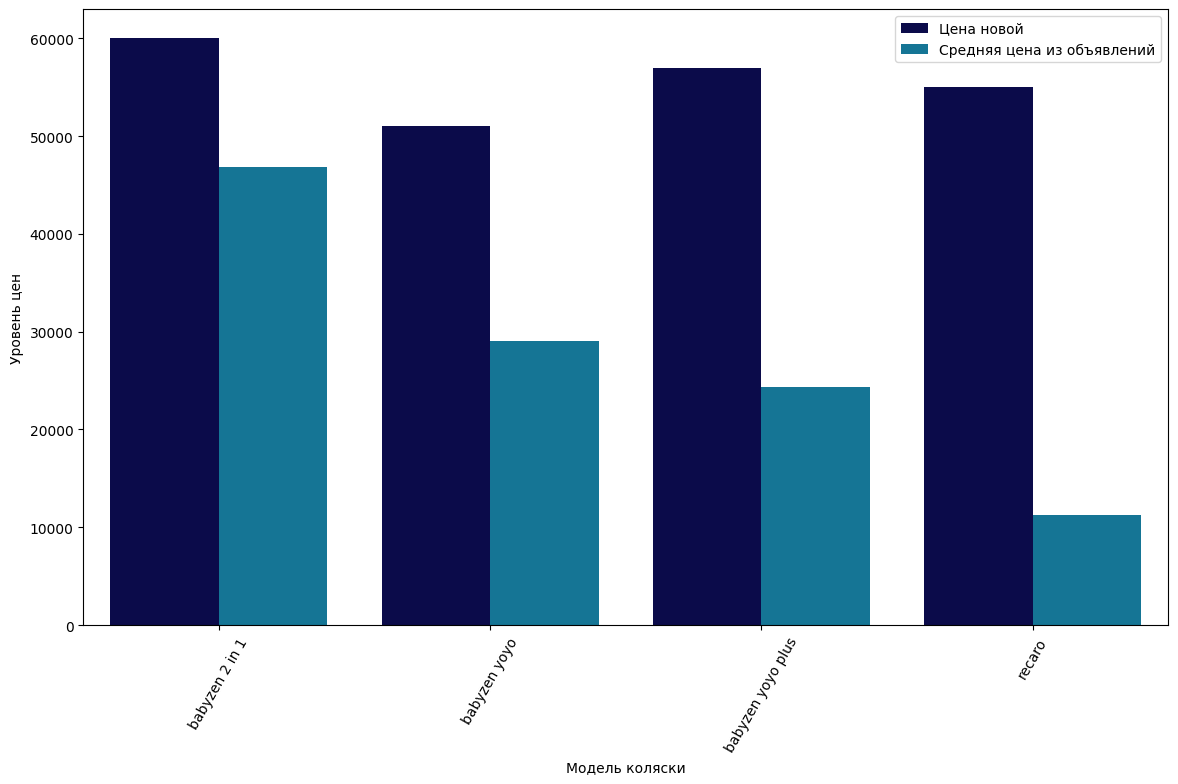

In [729]:
# Визулизируем
model_vizual(mask3 , 'ocean')

Тут вообще все непонятно, надо дальше смотреть. 

Следующий бренд Oyster

In [730]:
mask4 = df['Бренд']== 'oyster'
# собираем все модели этого бренда в разных вариантах их написания 
oyster_list = ['oyster zero', 'oyster 3', 'oyster atom']
# создаем список цен но новые коляски для этого бренда
oyster_pricelist = [30000, 50000, 20000 ]

# Заполняем столбцы "Модель" и "Цена новой"
get_model(mask4, oyster_list, oyster_pricelist)            
  
# проверим, что получилось
df[mask4]['Модель'].value_counts()

oyster zero    159
0               31
oyster 3        15
oyster atom      6
Name: Модель, dtype: int64

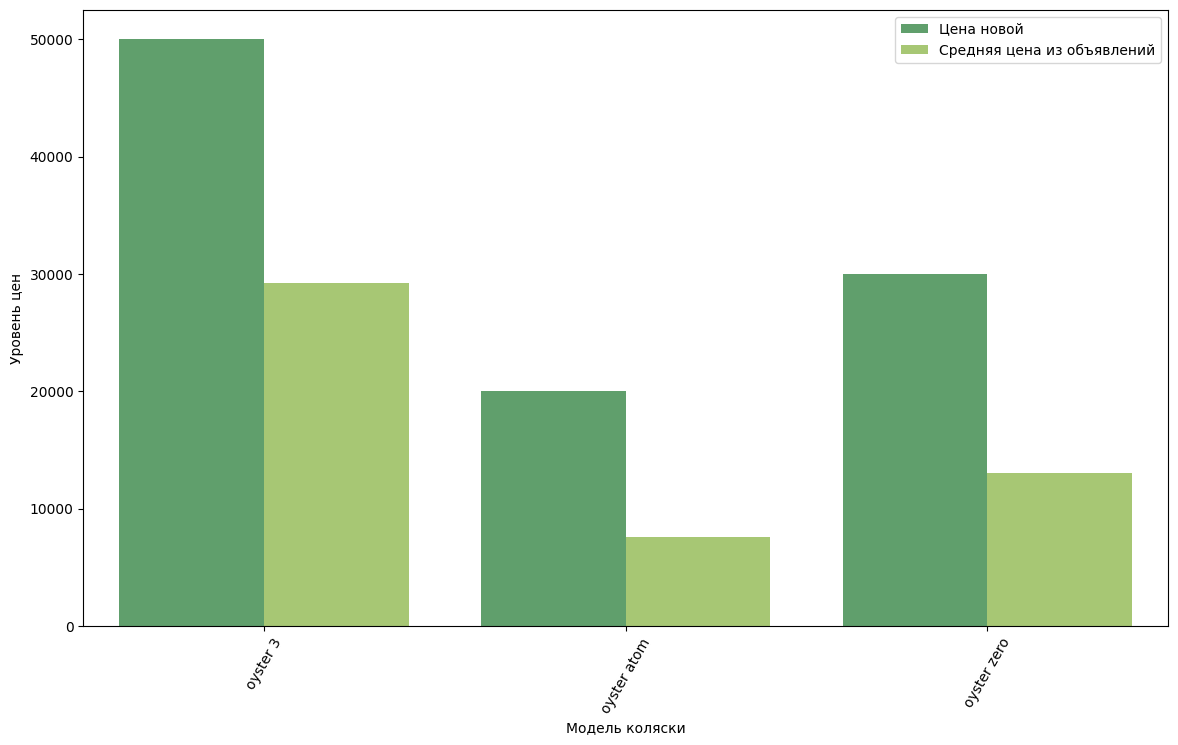

In [731]:
# визуализирем
model_vizual(mask4 , 'summer')

Здесь в среднем за полцены или меньше. 

Следущий бренд Mamas and Papas.

In [732]:
mask5 = df['Бренд']== 'mamas and papas'
# собираем все модели этого бренда в разных вариантах их написания 
mp_list = ['airo', 'cruise', 'occaro', '2 в 1','2в1' ,'sola', 'armadillo', '3 в 1', '3в1']
# создаем список цен но новые коляски для этого бренда
mp_pricelist = [28000, 20000, 28000, 40000, 40000, 23000, 20000, 50000, 50000 ]

# Заполняем столбцы "Модель" и "Цена новой"
get_model(mask5, mp_list, mp_pricelist)         
  
# проверим, что получилось
df[mask5]['Модель'].value_counts()

0            66
sola         16
armadillo     8
2 в 1         6
3 в 1         4
airo          4
2в1           3
3в1           1
cruise        1
Name: Модель, dtype: int64

In [733]:
# объединяем по смыслу значения
df['Модель'] = df['Модель'].apply(lambda x:
    'mp 2 in 1' if x == '2 в 1' or x == '2в1' \
    else 'mp 3 in 1' if x == '3 в 1' or x == '3в1' \
    else x )
# проверим
df[mask5]['Модель'].value_counts()

0            66
sola         16
mp 2 in 1     9
armadillo     8
mp 3 in 1     5
airo          4
cruise        1
Name: Модель, dtype: int64

Для типа "2 в 1" проверим, есть ли незаполненные в столбце "Модель" значения, которые можно взять из признака "Тип"

In [734]:
df[mask5&(df['Тип']== "2 in 1")&(df['Модель']==0)].shape[0]

11

Есть 11 строк, заполним их аналогично преобразованиям выше.

In [735]:
mp_2_in_1_list = list(df[mask5&(df['Тип']== "2 in 1")&(df['Модель']==0)].index)
df.loc[mp_2_in_1_list, 'Модель'] = 'mp 2 in 1'
df.loc[mp_2_in_1_list, 'Цена новой'] = 40000
# проверим
df[mask5&(df['Тип']== "2 in 1")&(df['Модель']==0)].shape[0]

0

Хорошо, теперь проверим для "3 в 1"

In [736]:
df[mask5&(df['Тип']== "3 in 1")&(df['Модель']==0)].shape[0]

2

Есть две строки, код у нас готов, заполним.

In [737]:
mp_3_in_1_list = list(df[mask5&(df['Тип']== "3 in 1")&(df['Модель']==0)].index)
df.loc[mp_3_in_1_list, 'Модель'] = 'mp 3 in 1'
df.loc[mp_3_in_1_list, 'Цена новой'] = 50000
# проверим
df[mask5&(df['Тип']== "3 in 1")&(df['Модель']==0)].shape[0]

0

Двигаемся дальше. Визуализируем распределение цен в рамках бренда Mamas and Papas

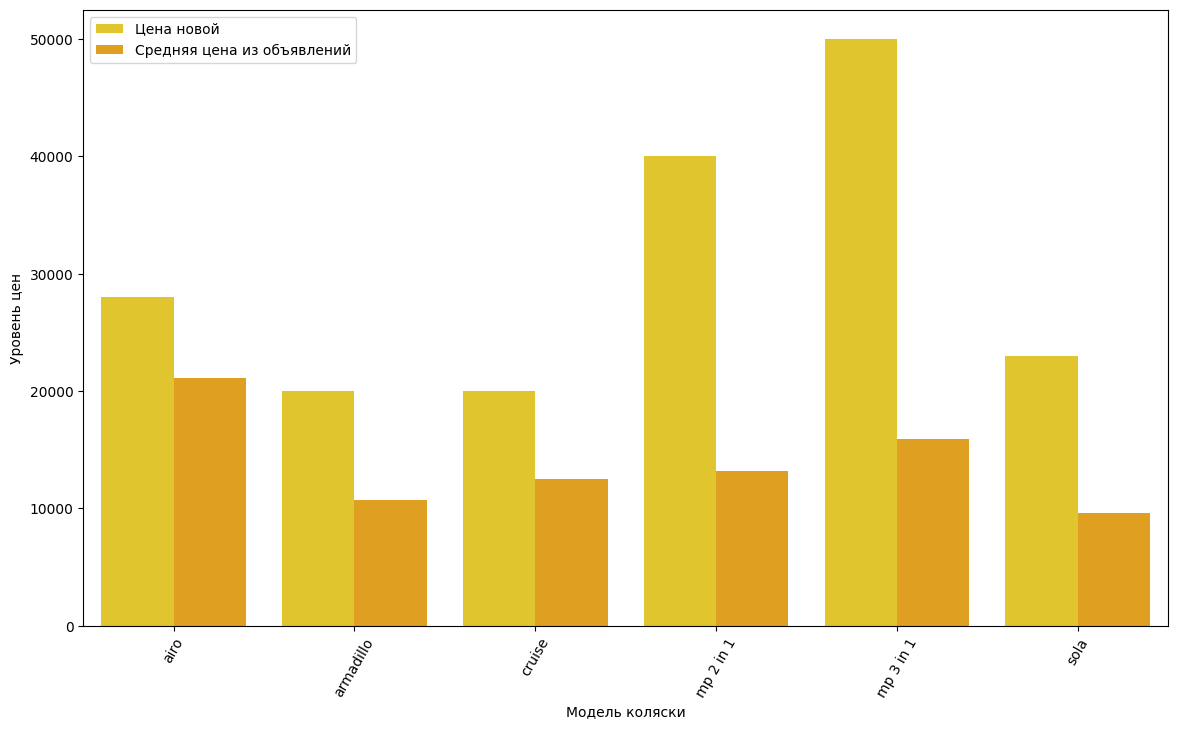

In [738]:
model_vizual(mask5, 'Wistia')

И последний бренд Thule

In [739]:
mask6 = df['Бренд']== 'thule'
df[mask6].head(2)

,Тип продавца,Заголовок,Описание,Цена,Город,Метро2,Дата объявления,Продавец. Магазин,Состояние,Бренд,Цвет,Тип,Модель,Цена новой
112,Частное лицо,коляска,"брендовая, качественная коляска urban detour. ...",6000,Апрелевка,нет метро,2022-11-01 23:07:18,Нет,Б/у,thule,Неизвестен,Прогулочная,0,0
154,Частное лицо,коляска thule sleek,"коляска для одного, двух и даже трех детей.исп...",45000,Москва,Волоколамская,2022-11-01 17:16:27,Нет,Б/у,thule,Синий,2 in 1,0,0


После некоторого анализа описаний и заголовков стало понятно, что есть две модели Urban GLide и Urban Glide 2, которые существенно отличаются в цене. Чтобы при написании нашего перебора-цикла программа не пометила Urban Glide 2 как Urban GLide, переименуем их сначала. И тоже самое для "Thule sleek 2 в 1".

In [740]:
df['Заголовок'] = df['Заголовок'].str.replace('urban glide 2', 'urban2')
df['Заголовок'] = df['Заголовок'].str.replace('thule sleek 2 в 1', '2 в 1')

In [741]:
# собираем все модели этого бренда в разных вариантах их написания 
thule_list = ['urban2', 'urban glide', "2 в 1" , "2в1" , "для двойни", "для погодок", "thule sleek"]
# создаем список цен но новые коляски для этого бренда
thule_pricelist = [85000, 60000, 90000, 90000, 100000, 100000, 80000]

# Заполняем столбцы "Модель" и "Цена новой"
get_model(mask6, thule_list, thule_pricelist)        
  
# проверим, что получилось
df[mask6].groupby('Модель')["Цена новой"].mean()

Модель
0                   0.0
2 в 1           90000.0
thule sleek     80000.0
urban glide     60000.0
urban2          85000.0
для двойни     100000.0
для погодок    100000.0
Name: Цена новой, dtype: float64

In [742]:
# объединяем по смыслу значения
df['Модель'] = df['Модель'].apply(lambda x:
    'thule для двойни' if x == 'для погодок' or x == 'для двойни' \
    else 'thule 2 in 1' if x == '2 в 1' \
    else x )
# проверим
df[mask6]['Модель'].value_counts()

thule для двойни    19
0                   16
thule sleek         15
urban glide         15
urban2              11
thule 2 in 1         3
Name: Модель, dtype: int64

In [743]:
# проверим 
df[mask6&(df['Тип']== "2 in 1")&(df['Модель']==0)].shape[0]

1

In [744]:
# присвоим значение
thule_2_in_1_list = list(df[mask6&(df['Тип']== "2 in 1")&(df['Модель']==0)].index)
df.loc[thule_2_in_1_list, 'Модель'] = 'thule 2 in 1'
df.loc[thule_2_in_1_list, 'Цена новой'] = 50000

In [745]:
# проверим для "3 в 1"
df[mask6&(df['Тип']== "3 in 1")&(df['Модель']==0)].shape[0]

3

Нашлось 3 строки, но Гугл не дает никаких колясок "3 в 1" у бренда Thule. Удалим их

In [746]:
del_list = list(df[mask6&(df['Тип'] == "3 in 1")&(df['Модель'] == 0)].index)
df = df.drop(del_list)
# проверим 
df[mask6&(df['Тип']== "3 in 1")&(df['Модель']==0)].shape[0]

0

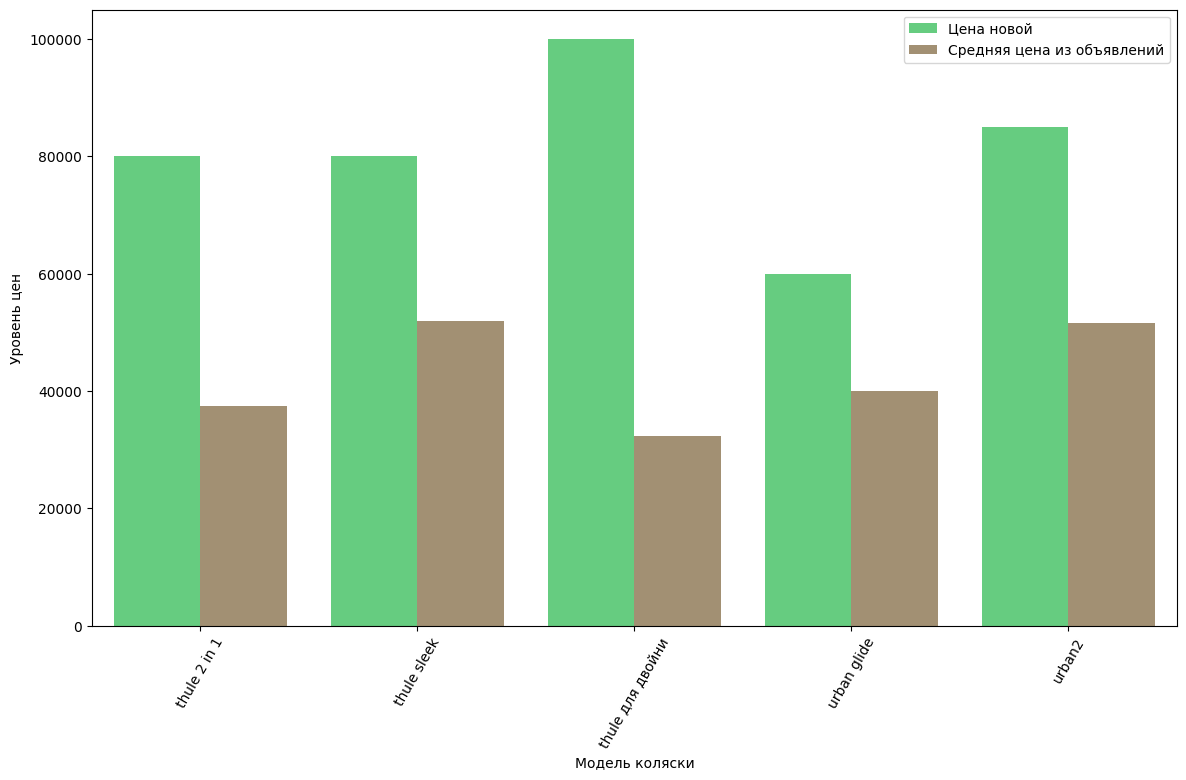

In [747]:
# посмотрим на графике
model_vizual(mask6, 'terrain')

Для самой дорогой категории колясок в этом бренде (для двойни) мы видим, что цена объявлений в среднем в три раза ниже цены новой коляски, что было характерно и для дорогого бренда Hartan. Для остальных моделей Thule в среднем цена объявления примерно вдвое ниже цены новой модели. Но опять же, еще многое зависит от состояния. Перейдем к нему скоро. 

С моделями колясок закончили, посмотрим, сколько осталось неразмеченных данных.

In [748]:
print(f'неизвестных моделей осталось {df[df["Модель"]==0].shape[0]}')
# удалим их
df = df[df['Модель']!=0]
print(f'неизвестных моделей осталось {df[df["Модель"]==0].shape[0]}, а известных {df[df["Модель"]!=0].shape[0]}')

неизвестных моделей осталось 244
неизвестных моделей осталось 0, а известных 1794


### Цвет

In [749]:
print(f'всего вариантов цвета: {df["Цвет"].nunique()-1}')
df['Цвет'].value_counts()

всего вариантов цвета: 16


Неизвестен      383
Серый           330
Синий           216
Чёрный          204
Белый           113
Красный         103
Коричневый       90
Зелёный          80
Бежевый          78
Фиолетовый       51
Розовый          44
Голубой          34
Бордовый         20
Разноцветный     19
Жёлтый           13
Оранжевый        10
Серебряный        6
Name: Цвет, dtype: int64

Имеем, что у нас 16 цветов + одно неизвестное значение, и топ 1 у нас неизвестный цвет, стоит ли его искать и вытаскивать по заголовкам и описаниям? Нужно посмотреть, важен ли цвет для нас вообще. Сначала просто посмотрим на распределение средней цены по цвету.

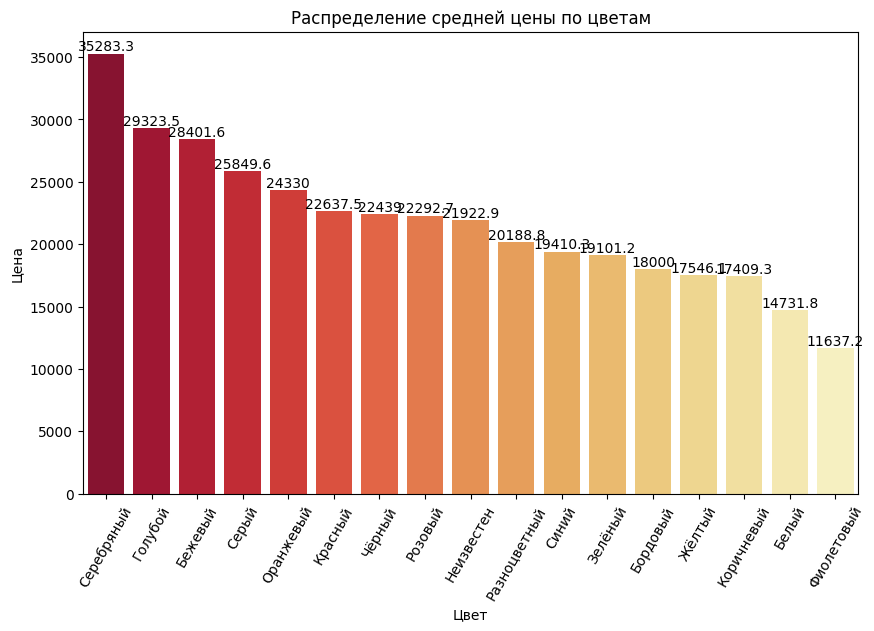

In [750]:
color_mean = df.groupby('Цвет')['Цена'].mean().sort_values(ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
bar = sns.barplot(data = color_mean, x ='Цвет', y ='Цена', palette = 'YlOrRd_r', ax = ax)
# выведем числовые значения
bar.bar_label(ax.containers[0])
# повернем подписи, чтобы не нагромождались
bar.xaxis.set_tick_params(rotation=60)
#задаём названия графикам
ax.set_title('Распределение средней цены по цветам')
fig.show()

Раница между первым и последним местом больше почти на 200%. Но, возможно, дело не в одном  только признаке цвета, а в цветах, которые используют более дорогие или более доступные по цене бренды. Построим тепловую карту, иллюстрирующую среднюю цену по бренду и цвету одновременно. 

In [751]:
pivot = df.pivot_table(values='Цена', index='Цвет', columns='Бренд', aggfunc = 'mean')
fig = px.imshow(pivot, height=600, width=600, color_continuous_scale='ylorbr')
fig.update_layout(title="Распределение средней цены коляски в зависимости от цвета и бренда")
fig.show()

 Видно, что для многих брендов вертикальная линия находится примерно в одной цветовой палитре, то есть дело больше в цвете,  а не бренде. Это логично.  Попробуем покопаться и достать цвета из описания, насколько получится, так как вариантов написаний для каждого еще больше: есть падежи, склонения и еще английские версии. 

In [752]:
# приведем все значения в столбце для работы к нижнему регистру для удобства
df['Цвет'] = df['Цвет'].str.lower()
mask7 = df['Цвет']=='неизвестен'
color_list = list(df['Цвет'].value_counts().index)
color_list.remove('неизвестен')
# создадим еще список,в котором будут значения, соответствующие вариантам написания цветов
add_color = ['grey', 'blue', 'black', 'white', 'red', 'brown', 'green', 'beige', 'violet', 'pink', 'blue', 'burgundy',
            'multi-colored', 'yellow', 'orange', 'silver', "синего", "черного", "белого", "красного", "коричневого",
            "зеленого", "бежевого", "фиолетового", "розового", "голубого", "бордового", "желтого", "оранжевого", "серебряного",
            "металлик"] 
# соединим списки
color_list.extend(add_color)

In [753]:
df['Цвет'].value_counts()

неизвестен      383
серый           330
синий           216
чёрный          204
белый           113
красный         103
коричневый       90
зелёный          80
бежевый          78
фиолетовый       51
розовый          44
голубой          34
бордовый         20
разноцветный     19
жёлтый           13
оранжевый        10
серебряный        6
Name: Цвет, dtype: int64

In [754]:
#  заменим значение в отфильтрованном признаке "Цвет" на значение из признака "Описание"
df.loc[df['Цвет'] == 'неизвестен', 'Цвет'] = df['Описание'].apply(lambda x: next((color for color in color_list if color in x.lower()), 'неизвестен'))


In [755]:
df[mask7]['Цвет'].value_counts()

неизвестен     344
серый           11
black            4
красного         3
белый            3
красный          3
чёрный           2
коричневый       2
grey             2
синего           2
white            1
blue             1
синий            1
коричневого      1
розового         1
green            1
silver           1
Name: Цвет, dtype: int64

Стало 342 неизвестных, то есть всего 37 значений удалось найти. Удалим строки с неизвестным цветом и переименуем то, что наловили в разных вариантах написания по смыслу.

In [756]:
df = df[df['Цвет']!='неизвестен']
# объединяем по смыслу значения
df['Цвет'] = df['Цвет'].apply(lambda x:
    'синий' if x == 'синего' or x == 'blue' \
    else 'черный' if x == 'black' \
    else 'коричневый' if x == 'коричневого' \
    else 'белый' if x == 'white' \
    else 'серый' if x == 'grey' \
    else 'красный' if x == 'красного' \
    else 'зелёный' if x == 'green' \
    else 'розовый' if x == 'розового' \
    else x )
# проверим
df['Цвет'].value_counts()

серый           343
синий           220
чёрный          206
белый           117
красный         109
коричневый       93
зелёный          81
бежевый          78
фиолетовый       51
розовый          45
голубой          34
бордовый         20
разноцветный     19
жёлтый           13
оранжевый        10
серебряный        6
черный            4
silver            1
Name: Цвет, dtype: int64

Все в порядке, двигаемся дальше.

### Тип продавца

Посмотрим на два признака и исследуем на идентичность: "Тип продавца" и "Продавец. Магазин"

In [757]:
df['Тип продавца'].value_counts()

Частное лицо    1347
Компания          92
Магазин           11
Name: Тип продавца, dtype: int64

In [758]:
df['Продавец. Магазин'].value_counts()

Нет    1439
Да       11
Name: Продавец. Магазин, dtype: int64

Перекодируем, чтобы проверить на идентичность. Переименуем в признаке "Тип продавца" частных лиц и компании, чтобы оставить только "Магазин" и "Нет" по аналогии с признаком "Продавец.Магазин"

In [759]:
seller_type = df['Тип продавца'].apply(lambda x: 'Нет' if x == 'Частное лицо' or x == 'Компания' else 'Да')
shop_type = df['Продавец. Магазин']
print((seller_type==shop_type).value_counts())


True    1450
dtype: int64


Они фактически совпадают, оставим из них признак "Тип продавца", так как в нем изначально было три типа значений ( "магазин", "частное лицо" и "компания", а в столбце "Продавец.магазин" значение "компания" просто соответствует значению "нет", как и "частное лицо").

In [760]:
df = df.drop('Продавец. Магазин', axis = 1)

Посмотрим на распределение этого признака по количеству и цене.

Text(0.5, 1.0, 'Распределение цены на коляски в зависимости от типа продавца')

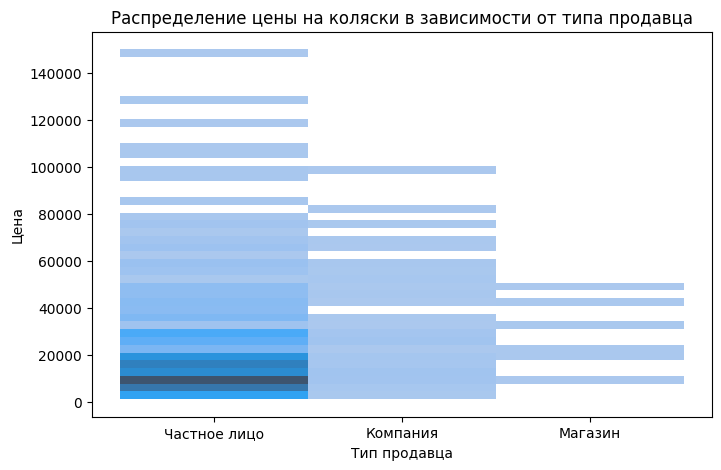

In [761]:
# задаем плоскость
fig, ax = plt.subplots(figsize=(8, 5))
# строим гистограмму
ax = sns.histplot(data = df, x = 'Тип продавца', y = 'Цена', ax = ax)
#задаём названия графикам
ax.set_title('Распределение цены на коляски в зависимости от типа продавца')

Видим, что наибольшее число колясок сосредоточено у частных лиц, как и показало исследование выше. При этом основное количество объявлений сосредоточено в ценовом диапазоне до 30000 с типом продавца "Частное лицо". 

### Город

Посмотрим на среднюю цену коляски в зависимости от города. 

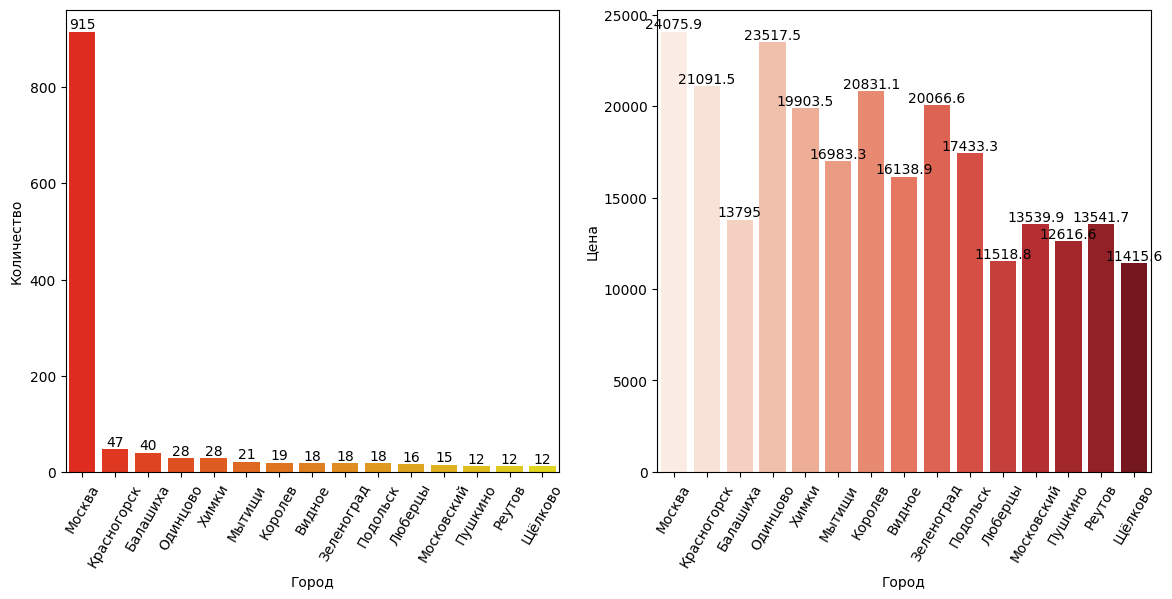

In [762]:
city_pivot = df.groupby('Город').agg({'Город':'count', 'Цена':'mean'}).rename(columns={'Город': 'Количество'}).nlargest(15, columns = 'Количество').reset_index()
# Построим график количества колясок и средней цены по городам.
fig, axes = plt.subplots(1,2, figsize=(14, 6))
bar = sns.barplot(data = city_pivot, x ='Город', y ='Количество', palette = 'autumn', ax = axes[0])
bar2 = sns.barplot(data = city_pivot, x ='Город', y ='Цена', palette = 'Reds', ax = axes[1])
bar.bar_label(axes[0].containers[0])
bar2.bar_label(axes[1].containers[0])
bar.xaxis.set_tick_params(rotation=60)
bar2.xaxis.set_tick_params(rotation=60)
fig.show()

Видим, что подавляющее большинство предложений относятся к Москве, на втором месте Красногорск с отрывом в 20 раз почти. Оставим два значения: Москва и область.

In [763]:
df['Город'] = df['Город'].apply(lambda x: 'Москва' if x == 'Москва' else 'Область')
df['Город'].value_counts()

Москва     915
Область    535
Name: Город, dtype: int64

#### Статистический анализ данных для городов


Попробуем ответить на вопрос: средняя цена на коляски из объявления для области больше, чем для Москвы? 
Сформулируем нулевую и альтернативные гипотезы:

Нулевая гипотеза ($H_0$): средняя цена для области ($μ_1$) статистически меньше либо равна средней цене для Москвы ($μ_2$).
$$ H_0 : μ_1 <= μ_2$$
Альтернативная гипотеза ($H_1$): средняя цена для области ($μ_1$) статистически больше, чем для Москвы ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

С помощью теста Шапиро-Уилка проверим, распределён ли признак цены нормально. 

Гипотеза теста Шапиро-Уилка: 
- *Нулевая гипотеза* ($H_0$): распределение данные является нормальным.
- *Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

Создадим функцию для принятия решения о нормальности и для принятия решения об отклонении нулевой гипотезы

In [764]:
# значения цены
price_region = df.loc[df['Город']=='Область', 'Цена']
price_moscow = df.loc[df['Город']=='Москва', 'Цена']

# проводим тест Шапиро-Уилка
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
# Установим уровень значимости
alpha = 0.05

Для области проверим

In [765]:
_, p = shapiro(price_region)
print('p=%.3f' % p)

# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


Для Москвы

In [766]:
_, p = shapiro(price_moscow)
print('p=%.3f' % p)

# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


Выберем подходящий статистический тест: для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Цена»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.
Проведём тест

In [767]:
# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      
# проводим тест
_, p = stats.mannwhitneyu(price_region, price_moscow, alternative='greater')
decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Нет оснований утверждать, что средняя цена для регионов выше, чем для Москвы.

### Состояние

Посмотрим на соотношение количества б/у и новых колясок:

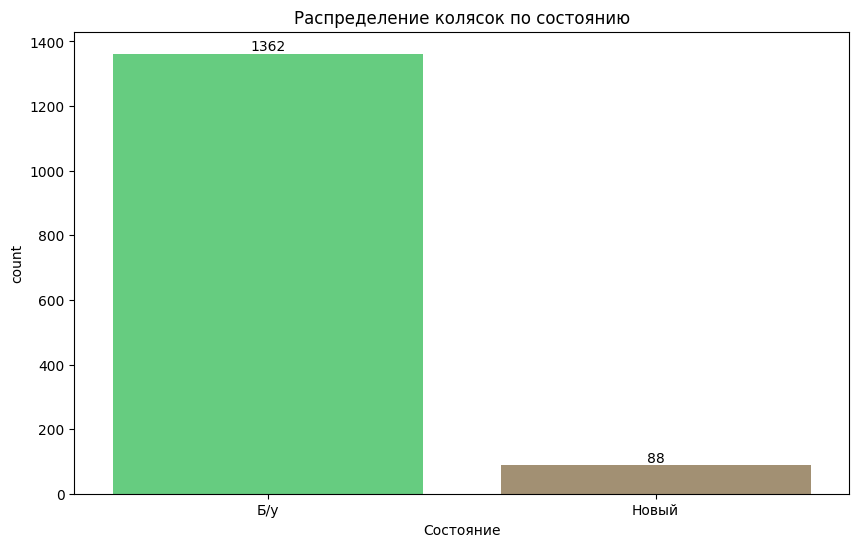

In [768]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.countplot(data=df, x='Состояние', palette = 'terrain')
ax.bar_label(ax.containers[0])
ax.set_title('Распределение колясок по состоянию')
fig.show()

Видим, что намного меньше, чем б/у колясок. Это неудивительно, ведь формат Авито как раз и предполагает объявления о продаже бывших в употреблении вещей. В процессе изучения описаний этого признака было выявлено, что некоторые коляски со статусом "Новый" все же являются б/у , просто в очень хорошем состоянии. К тому же мы пытаемся предсказать цену на б/у коляски, а для новых у нас есть отдельный признак. Чтобы не путать модель, удалим все строки со значением "Новый".

In [769]:
df = df[df['Состояние']!="Новый"]
# нам больше не нужен этот признак, так как в нем теперь одно уникальное значение, удалим его
df = df.drop('Состояние', axis = 1)

### Дата

Рассмотрим признак даты. 

In [770]:
df['Дата объявления'].describe()

count                    1362
unique                   1362
top       2022-11-02 21:40:27
freq                        1
first     2022-10-03 08:07:14
last      2022-11-02 21:40:27
Name: Дата объявления, dtype: object

Видим, что после очистки/преобразований у нас есть данные с 3 октября по 2 ноября, то есть за месяц всего. Построим временной ряд 

In [771]:
time_df = df[['Дата объявления', 'Цена']].copy()
time_df['Дата объявления'] = pd.to_datetime(time_df['Дата объявления'])
time_df.set_index('Дата объявления', inplace=True)
time_df.head()

,Цена
Дата объявления,
2022-11-02 21:40:27,8000
2022-11-02 21:33:23,9700
2022-11-02 21:03:47,20000
2022-11-02 20:41:39,35000
2022-11-02 19:43:03,20000


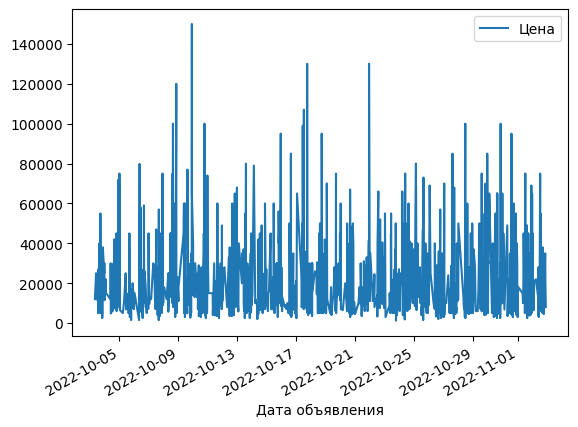

In [772]:
fig = time_df.plot()
plt.show()

In [773]:
from statsmodels.tsa.stattools import adfuller
test1 = adfuller(time_df)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -36.807024768780835
p-value:  0.0
Critical values:  {'1%': -3.435163869552687, '5%': -2.863665960737661, '10%': -2.567901861810129}
ряд стационарен


На данном графике нет какого-либо тренда и сезонности, ряд стационарен, значение цены существенно варьируется по дням, но какой-либо зависимости не прослеживается. Удалим этот признак.

In [774]:
df = df.drop('Дата объявления', axis =1 )

### ОПИСАНИЕ

После некоторого чтения/исследования этого признака я выделила следующие составляющие, которые могут влиять на цену: отличное состояние (в отличном состоянии, шикарная, в шикарном состоянии, в прекрасном состоянии, в идеальном состоянии, супер), для двоих детей (двойня, погодки, близнецы), есть ли потертости и/или ржавчина или просто хорошее состоние.
Попробуем создать новые признаки на основе этой информации. И создадим новый признак "Состояние"

### Отличное состояние

In [775]:
# создаем соответствующий столбец 
df['Состояние'] = "неизвестное"
# создаем список с фразами метками 
excellent_list = ['отличном состоянии', 'отличное состояние', 'состояние отличное', 'в идеальном состоянии', 'идеальное состояние',
             "состояние идеальное", "шикарное состояние", "в прекрасном состоянии", "как новая", "состояние идеальное", "новая коляска",
             "новой коляски", "почти новая", "практически новая", 'в отличнейшем состоянии', "практически новая"]
# заполняем в столбце, если в описании данной строки присутствует фраза-метка
for value in excellent_list:
    df.loc[df['Описание'].str.contains(value), 'Состояние'] = "отличное"

# проверим, что получилось
df['Состояние'].value_counts()

неизвестное    897
отличное       465
Name: Состояние, dtype: int64

### Хорошее состояние

In [776]:
# создаем список с фразами метками 
good_list = ["в хорошем состоянии", "хорошее состояние", "в очень хорошем состоянии", 'состояние очень хорошее', 'состояние хорошее',
             'состояние коляски хорошее', 'не сломано', "в рабочем состоянии", "в хорошем стоянии", "в нормальном состоянии"]
# заполняем, если в описании данной строки присутствует фраза-метка
for value in good_list:
    df.loc[df['Описание'].str.contains(value), 'Состояние'] = "хорошее"
    
# проверим, что получилось
df['Состояние'].value_counts()

неизвестное    523
отличное       446
хорошее        393
Name: Состояние, dtype: int64

### Состояние ниже среднего

In [777]:
# создаем список с фразами метками 
ok_list = ['ржавчина', 'ржавчиной', 'сломаны', 'поломаны', 'отломаны', 'сломана', 'поломана', 'отломана',
            'сломан', 'поломан', 'отломан', 'не работает', 'на запчасти', 'удовлетворительном состоянии', 
            'состояние удовлетворительное', 'удовлетворительное состояние',
            'выцвел', 'выцвела']
# заполняем, если в описании данной строки присутствует фраза-метка
for value in ok_list:
    df.loc[df['Описание'].str.contains(value), 'Состояние'] = "ниже среднего"

# проверим, что получилось
df['Состояние'].value_counts()

неизвестное      501
отличное         440
хорошее          367
ниже среднего     54
Name: Состояние, dtype: int64

И у нас осталось еще много колясок с неизвестным состоянием. После изучения описаний этой части я сделала вывод, что  почти все эти коляски в отличном либо хорошем состоянии. Оставим их

Text(0.5, 1.0, 'Средняя цена на коляски в зависимости от состояния')

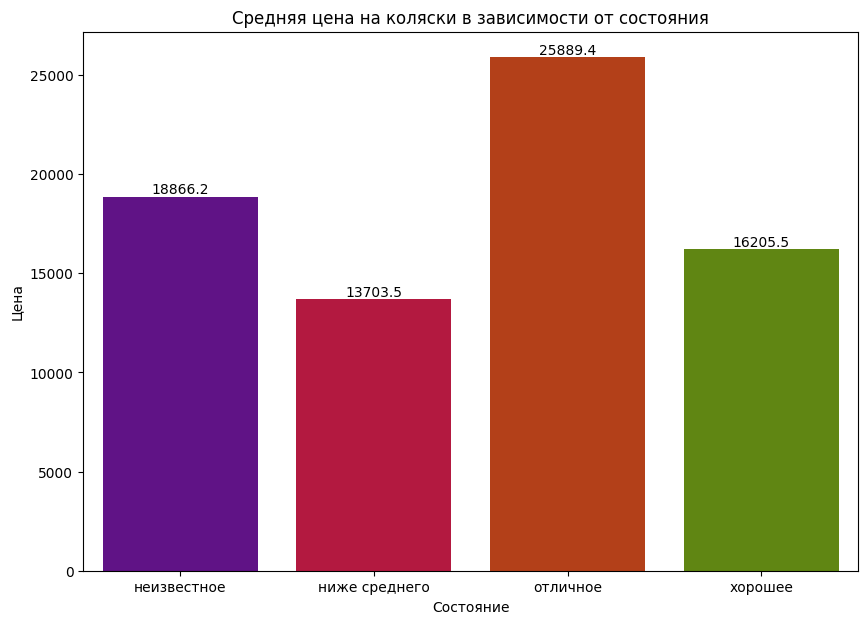

In [778]:
# задаем плоскость
fig, ax = plt.subplots(figsize=(10, 7))
# строим гистограмму
ax = sns.barplot(data = df.groupby(['Состояние'], as_index=False)['Цена'].mean(),
                       x = 'Состояние', y = 'Цена', ax = ax, palette= 'brg')
ax.bar_label(ax.containers[0])
#задаём названия графикам
ax.set_title('Средняя цена на коляски в зависимости от состояния')

Построим еще тепловую карту распределения средней цены в зависимости от модели и состояния

In [779]:
pivot = df.pivot_table(values='Цена', index='Состояние', columns='Модель', aggfunc = 'mean')
fig = px.imshow(pivot, height=600, width=1200, color_continuous_scale='blues')
fig.update_layout(title="Распределение средней цены коляски в зависимости от модели и состояния")
fig.show()

Для состояние "неизвестное" распределение очень похоже на "хорошее". Переименуем

In [780]:
df.loc[df['Состояние'] == 'неизвестное', 'Состояние'] = 'хорошее'

Вернемся к признаку "Тип"

In [781]:
df['Тип'].value_counts()

2 in 1         592
Прогулочная    546
Другой         119
3 in 1          59
Трансформер     26
Трость          10
Люлька          10
Name: Тип, dtype: int64

Удалим строки со значением "Другой", чтобы не путать модель.

In [782]:
df = df[df['Тип']!= "Другой"]

In [783]:
# размер датасета после всех преобразований
df.shape

(1243, 12)

Удалим признаки, которые нам уже не нужны.

In [784]:
df = df.drop(columns=['Заголовок', 'Описание'])
# посмотрим на датасет перед кодированием еще раз
df.head()

,Тип продавца,Цена,Город,Метро2,Бренд,Цвет,Тип,Модель,Цена новой,Состояние
1,Частное лицо,8000,Область,нет метро,hartan,белый,Прогулочная,hartan racer gt,129000,хорошее
2,Частное лицо,9700,Москва,Бунинская аллея,oyster,зелёный,Прогулочная,oyster zero,30000,хорошее
9,Частное лицо,20000,Москва,Алексеевская,hartan,бежевый,2 in 1,hartan vip,120000,отличное
11,Частное лицо,35000,Москва,ВДНХ,britax,бежевый,2 in 1,britax smile 3,70000,хорошее
12,Частное лицо,20000,Москва,Рассказовка,babyzen,красный,Прогулочная,babyzen yoyo,51000,хорошее


# Кодирование признаков

In [785]:
df.describe()

,Цена,Цена новой
count,1243.000000,1243.000000
mean,20281.827836,74616.251006
std,18588.323230,42630.721118
min,1200.000000,20000.000000
25%,9000.000000,30000.000000
50%,14500.000000,70000.000000
75%,25000.000000,115000.000000
max,149990.000000,160000.000000


Посмотрим на распределение категориальных признаков

In [786]:
df.describe(include='object')

,Тип продавца,Город,Метро2,Бренд,Цвет,Тип,Модель,Состояние
count,1243,1243,1243,1243,1243,1243,1243,1243
unique,3,2,184,6,16,6,36,3
top,Частное лицо,Москва,нет метро,hartan,серый,2 in 1,hartan 2 in 1,хорошее
freq,1174,764,370,616,276,592,408,802


Закодируем признаки, в которых больше 15 уникальных значений бинарно

In [787]:
# создаем кодировщик
bin_encoder = ce.BinaryEncoder(cols=['Модель', "Цвет", "Метро2"]) 
# создаем закодированные из признака "Бренд" столбцы
df_bin_encoded = bin_encoder.fit_transform(df[['Модель', "Цвет", "Метро2"]])
# объединяем
df = pd.concat([df, df_bin_encoded], axis=1)
# удалим оставшиеся ненужные признаки
df = df.drop(columns=["Цвет", "Модель", "Метро2"])

А остальные горячим кодированием. 

In [788]:
columns_to_encode = ['Состояние', "Тип продавца", "Тип", "Город", "Бренд"]
# применяем горячее кодирование к столбцам
df = pd.get_dummies(df, columns=columns_to_encode)
df.shape

(1243, 41)

# Корреляция

<AxesSubplot: >

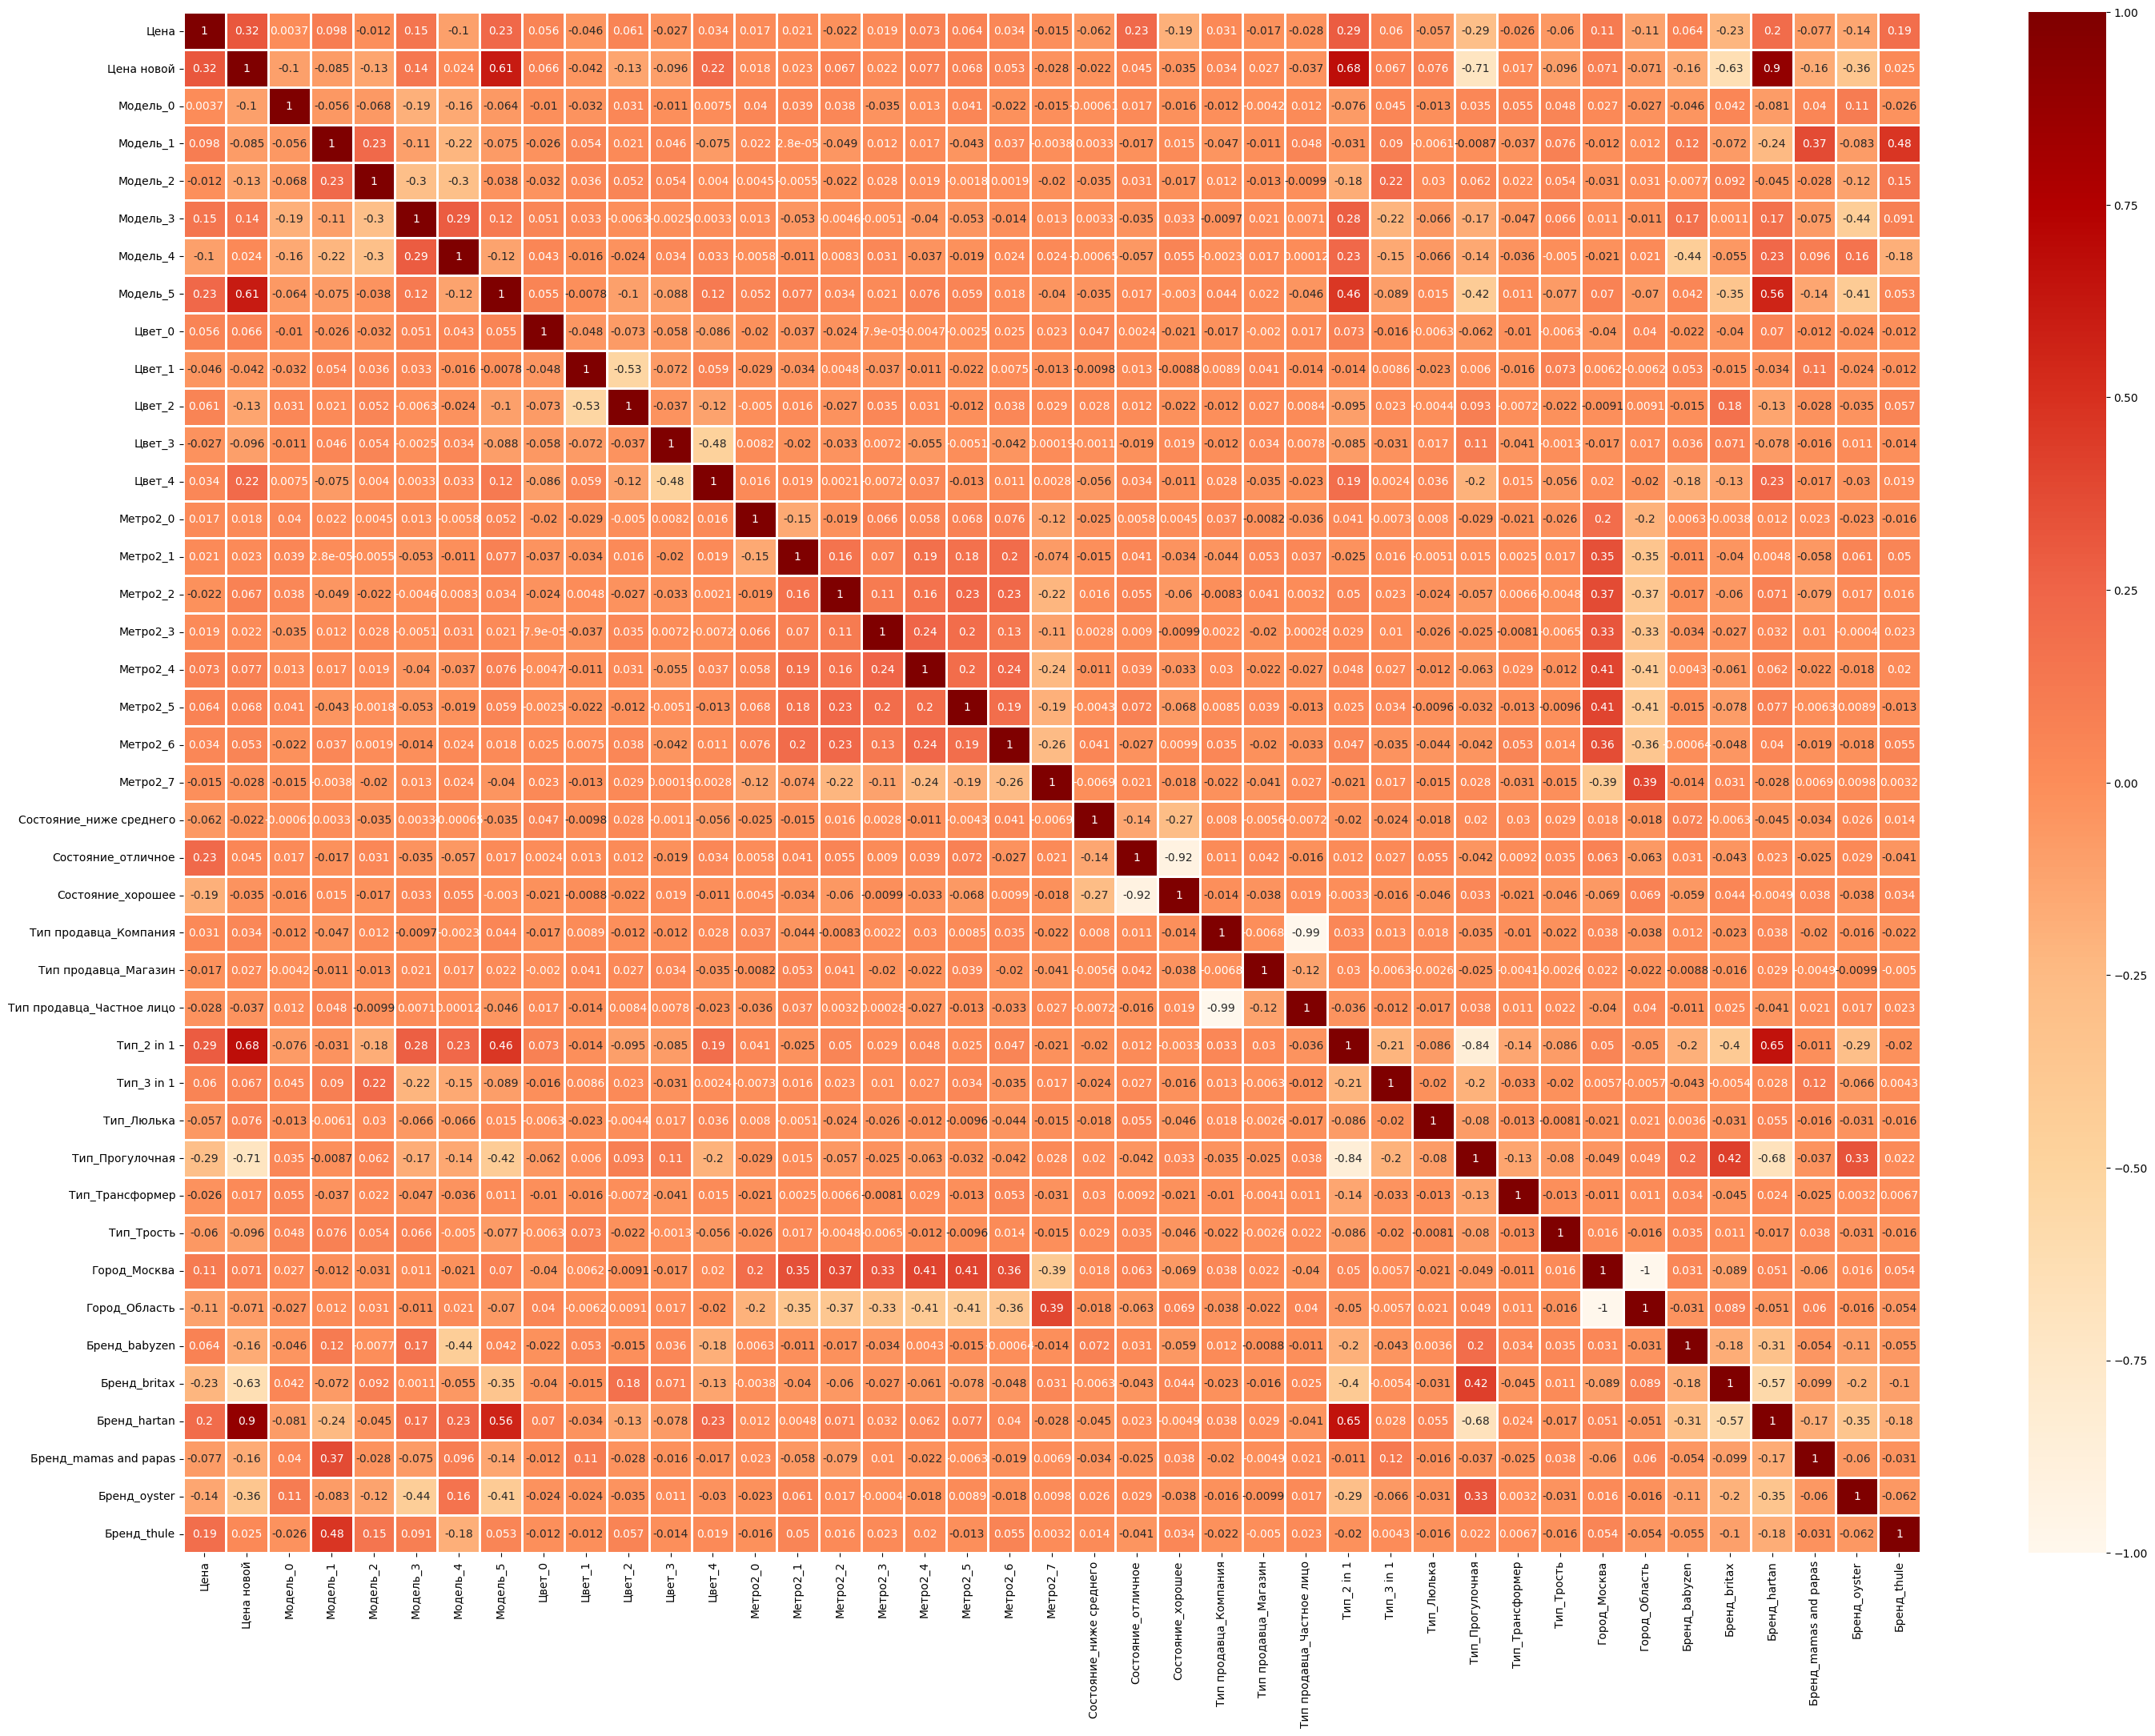

In [789]:
fig, ax = plt.subplots(figsize=(35,25))
sns.heatmap(df.corr(), annot=True, linewidths=.8, ax=ax, cmap = 'OrRd' )

Удалим признаки, обладающие мультиколлинеарностью с коэффициентом не меньше 0.9 по модулю.

In [790]:
df = df.drop(columns=['Город_Москва', 'Бренд_hartan', 'Тип продавца_Компания', "Состояние_хорошее"], axis =1)

# Отбор признаков и стандартизация

Теперь, когда все признаки предобработаны, сформируем матрицу наблюдений X и вектор целевой переменной y. 

In [791]:
X = df.drop(['Цена'], axis=1)
y = df['Цена']
X.shape

(1243, 36)

Разделим выборку на тренировочную и тестовую. А так же потом попробуем сделать кросс-валидацию на общей выборке на некоторых моделях.
Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [792]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

Оставим лишь те признаки, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели. 
С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной.

In [793]:
# отбираем признаки
selector = feature_selection.SelectKBest(k = 25)
selector.fit(X_train, y_train)

# оставляем только полученные 25 признаков
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_test = X_test[best_features]

print('Признаки, которые вошли в список отобранных:\n', best_features)

Признаки, которые вошли в список отобранных:
 ['Цена новой' 'Модель_1' 'Модель_2' 'Модель_3' 'Модель_4' 'Модель_5'
 'Цвет_0' 'Цвет_4' 'Метро2_1' 'Метро2_2' 'Метро2_3' 'Метро2_4' 'Метро2_6'
 'Метро2_7' 'Состояние_отличное' 'Тип_2 in 1' 'Тип_3 in 1'
 'Тип_Прогулочная' 'Тип_Трансформер' 'Тип_Трость' 'Город_Область'
 'Бренд_babyzen' 'Бренд_britax' 'Бренд_oyster' 'Бренд_thule']


Теперь проведем стандартизацию 

In [794]:
# инициализируем 
ss_scaler = preprocessing.StandardScaler()
# преобразуем данные
X_train = ss_scaler.fit_transform(X_train)
X_test = ss_scaler.transform(X_test)

# составляем DataFrame из массивов
X_train = pd.DataFrame(X_train, columns = best_features)
X_test = pd.DataFrame(X_test, columns = best_features)

Отбираем 25 лучших признаков для неразделенной выборки

In [795]:
# отбираем признаки
selector_X = feature_selection.SelectKBest(k = 25)
selector_X.fit(X, y)

# оставляем только полученные 25 признаков
best_features_X = selector_X.get_feature_names_out()
X = pd.DataFrame(X, columns = best_features_X)
print('Признаки, которые вошли в список отобранных:\n', best_features_X)

Признаки, которые вошли в список отобранных:
 ['Цена новой' 'Модель_1' 'Модель_3' 'Модель_4' 'Модель_5' 'Цвет_0'
 'Цвет_4' 'Метро2_1' 'Метро2_2' 'Метро2_3' 'Метро2_4' 'Метро2_6'
 'Метро2_7' 'Состояние_отличное' 'Тип продавца_Частное лицо' 'Тип_2 in 1'
 'Тип_3 in 1' 'Тип_Прогулочная' 'Тип_Трансформер' 'Тип_Трость'
 'Город_Область' 'Бренд_babyzen' 'Бренд_britax' 'Бренд_oyster'
 'Бренд_thule']


Проводим стандартизацию

In [796]:
# инициализируем 
s_scaler = preprocessing.StandardScaler()
# кодируем неразделенный датасет
X = s_scaler.fit_transform(X)

# Обучение моделей

### ЛИНЕЙНАЯ РЕГРЕССИЯ

Начнем с линейной регрессии на тренировочной и тестовой выборке с параметрами по умолчанию. Для оценки качества предсказания будем смотреть коэффициент детерминации R^2.

### Линейная регрессия

In [797]:
# создаём модель линейной регрессии
lr = LinearRegression()
# обучаем модель - ищем параметры МНК
lr.fit(X_train, y_train)

#  делаем предсказания
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# рассчитываем метрики
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

R^2 на тренировочной выборке 0.27
R^2 на тестовой выборке 0.21


Линейная регрессия с кросс-валидацией c параметрами по умолчанию

In [798]:
# создаём модель линейной регрессии
lr_cv = LinearRegression()
# Создание объекта KFold
kf = model_selection.KFold(n_splits=9)
scores = model_selection.cross_validate(lr_cv, X, y, cv=kf, return_train_score=True,
         scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'])

# Вывод результатов
print("Train R^2 Score:", round(scores['train_r2'].mean(), 2))
print("Test R^2 Score:", round(scores['test_r2'].mean(), 2))

Train R^2 Score: 0.26
Test R^2 Score: 0.22


###  Линейная регрессия с L-1 регуляризацией и подбором параметров.

In [799]:
# воспользуемся методом случайного поиска для подбора параметра альфа
param_grid = {'alpha': list(np.linspace(0.01, 30, 100, dtype=float))}
model_lasso = Lasso()
random_search = RandomizedSearchCV(
   estimator = model_lasso, 
   param_distributions = param_grid, 
   n_iter = 100, 
   random_state=42)
random_search.fit(X_train, y_train)
print(f"Наилучшие значения гиперпараметров: {random_search.best_params_}")

# создаём модель линейной регрессии c L1-регуляризацией
lasso = Lasso(alpha=random_search.best_estimator_.alpha, max_iter=10000 , random_state = 42)

# оцениваем качество модели на кросс-валидации, метрика R^2
cv_results_l1 = cross_validate(lasso, X_train, y_train, 
                scoring='r2', 
                cv=6, return_train_score=True)
print(f"на тренировочных фолдах R^2 = {round(cv_results_l1['train_score'].mean(),2)} ")
print(f"на валидационных фолдах R^2 = {round(cv_results_l1['test_score'].mean(),2)} ")

Наилучшие значения гиперпараметров: {'alpha': 17.276969696969697}
на тренировочных фолдах R^2 = 0.27 
на валидационных фолдах R^2 = 0.21 


Обучим на этих параметрах разделенную тренировочную выборку и посмотрим результат на тестовой. 

In [800]:
lasso_1 = Lasso(alpha= 30, max_iter=10000, random_state = 42)
lasso_1.fit(X_train, y_train)

#  делаем предсказания
y_train_pred = lasso_1.predict(X_train)
y_test_pred = lasso_1.predict(X_test)

# рассчитываем метрики
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

R^2 на тренировочной выборке 0.27
R^2 на тестовой выборке 0.21


### Линейная регрессия с L-1 и L-2 регуляризацией и подбором параметров.

In [801]:
params = {'alpha':list(np.linspace(0.05, 30, 100, dtype=float)), 'l1_ratio': list(np.linspace(0.1, 50, 100, dtype=float))}
         
model_elnet = ElasticNet()
# проведем подбор параметров по сетке
gr = GridSearchCV(model_elnet, params, cv=7, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
gr.fit(X,y)

print(f'наилучший коэффициент альфа {gr.best_estimator_.alpha}')
print(f'наилучший коэффициент лямбда {gr.best_estimator_.l1_ratio}')

# создаём модель линейной регрессии c L1- и L2-регуляризациями
el_net = ElasticNet(alpha=gr.best_estimator_.alpha,
                    l1_ratio=gr.best_estimator_.l1_ratio,
                    max_iter=10000, 
                    random_state = 42)

# оцениваем качество модели на кросс-валидации
cv_results_elnet = cross_validate(el_net, X, y, 
            scoring='r2', 
            cv=7, return_train_score=True)

print(f"на тренировочных фолдах: {round(cv_results_elnet['train_score'].mean(),2)} ")
print(f"на валидационных фолдах: {round(cv_results_elnet['test_score'].mean(),2)} ")

наилучший коэффициент альфа 0.05
наилучший коэффициент лямбда 0.604040404040404
на тренировочных фолдах: 0.26 
на валидационных фолдах: 0.23 


Сделаем тоже самое для разделенной выборки.

In [802]:
params = {'alpha':list(np.linspace(0.05, 30, 100, dtype=float)), 'l1_ratio': list(np.linspace(0.1, 50, 100, dtype=float))}
         
model_elnet = ElasticNet()
gr = GridSearchCV(model_elnet, params, cv=7, n_jobs=-1, scoring='r2')
gr.fit(X_train,y_train)

print(f'наилучший коэффициент альфа {gr.best_estimator_.alpha}')
print(f'наилучший коэффициент лямбда {gr.best_estimator_.l1_ratio}')

el_net = ElasticNet(alpha=gr.best_estimator_.alpha,
                    l1_ratio=gr.best_estimator_.l1_ratio,
                    max_iter=10000,
                    random_state = 42)

el_net.fit(X_train, y_train)
#  делаем предсказания
y_train_pred = el_net.predict(X_train)
y_test_pred = el_net.predict(X_test)

# рассчитываем метрики
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

наилучший коэффициент альфа 0.3525252525252525
наилучший коэффициент лямбда 0.604040404040404
R^2 на тренировочной выборке 0.26
R^2 на тестовой выборке 0.2


Попробуем создать из наших признаков полином 2 степени и обучить его сразу на эластичной сетке, так как полиномы очень склонны к переобучению.

### Полином на эластичной сетке

In [803]:
# создадим полиномиальную регрессию 2 степени 
poly = PolynomialFeatures(degree=2, include_bias= False)
X_poly = poly.fit_transform(X)

In [804]:
params = {'alpha':list(np.linspace(0.05, 30, 100, dtype=float)), 'l1_ratio': list(np.linspace(0.1, 50, 100, dtype=float))}
         
model_elnet = ElasticNet()
gr = GridSearchCV(model_elnet, params, cv=7, n_jobs=-1, scoring='r2')
gr.fit(X_poly, y)

print(f'наилучший коэффициент альфа {gr.best_estimator_.alpha}')
print(f'наилучший коэффициент лямбда {gr.best_estimator_.l1_ratio}')

# создаём модель линейной регрессии c L1- и L2-регуляризациями
el_net = ElasticNet(alpha=gr.best_estimator_.alpha,
                    l1_ratio=gr.best_estimator_.l1_ratio,
                    max_iter=10000,
                    random_state = 42)

# оцениваем качество модели на кросс-валидации
cv_results_elnet = cross_validate(el_net, X_poly, y, 
            scoring='r2', 
            cv=7, return_train_score=True)

print(f"на тренировочных фолдах: {round(cv_results_elnet['train_score'].mean(),2)} ")
print(f"на валидационных фолдах: {round(cv_results_elnet['test_score'].mean(),2)} ")

наилучший коэффициент альфа 1.8651515151515152
наилучший коэффициент лямбда 0.604040404040404
на тренировочных фолдах: 0.38 
на валидационных фолдах: 0.25 


Все равно видим переобучение и низкий R^2

Видим, что обучение на тренировочной выборке и на полной выборке с кросс-валидацией не меняет сути дела - коэффициент детерминации в первом и втором случае на тесте почти одинаковый для всех видов моделей, которые мы построили. К тому же видим, что он очень низкий. При этом для кросс-валидации надо еще подбирать количество фолдов, тк от него зависит качество предсказания тоже. 
Пока построенные модели не смогли хорошо уловить зависимость в признаках и на тренировочных данных, и, соответственно, на тестовых. Продолжим обучение моделей на разделенной train/test выборке и перейдем к деревьям решений и ансамблям.

### ДЕРЕВЬЯ РЕШЕНИЙ 

### Дерево решений с параметрами по умолчанию

In [805]:
# Создаем объект класса дерево решений
dt = tree.DecisionTreeRegressor()
# Обучаем дерево 
dt.fit(X_train, y_train)
# Делаем предсказание и выводим значения метрики R^2
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

R^2 на тренировочной выборке 0.73
R^2 на тестовой выборке -0.36


Такая модель нам совсем не годится, здесь очень сильное переобучение налицо. Попробуем подобрать параметры.

In [806]:
param_grid = {'min_samples_leaf': [4, 10],
              'max_depth': list(np.linspace(5, 40, 10, dtype=int)),
              'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
              }
random_search = RandomizedSearchCV(
    estimator= tree.DecisionTreeRegressor(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 15, 
    n_jobs = -1)   
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# создаем объект класс дерево решений и обучаем модель
best_tree = tree.DecisionTreeRegressor(**best_params, random_state = 42)
best_tree.fit(X_train,y_train)

# Делаем предсказание и выводим значения метрики R^2
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

Best Parameters: {'min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'poisson'}
R^2 на тренировочной выборке 0.3
R^2 на тестовой выборке 0.08


И снова видим переобучение и цифры, похожие на результаты, полученные в моделях линейной регрессии. Перейдем к ансамблям и сразу будем подбирать гиперпараметры поиском по рандомизированной сетке.

### Случайный лес 

In [807]:
param_grid = {'n_estimators': list(range(100, 200, 20)),
              'min_samples_leaf': [5, 9],
              'max_depth': list(np.linspace(5, 40, 10, dtype=int)),
              'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
              }
# задаем поиск по рандомизированной сетке
random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestRegressor(random_state=42), 
    param_distributions=param_grid, 
    cv=7,
    n_iter = 15, 
    n_jobs = -1)   
# обучим на нашей выборке
random_search.fit(X_train, y_train)
# выведем лучшие параметры
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# создаем объект класса случайный лес
rf_best = ensemble.RandomForestRegressor(**best_params, random_state = 42)
rf_best.fit(X_train,y_train)

# Делаем предсказание и выводим значения метрики R^2
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

Best Parameters: {'n_estimators': 100, 'min_samples_leaf': 9, 'max_depth': 40, 'criterion': 'squared_error'}
R^2 на тренировочной выборке 0.38
R^2 на тестовой выборке 0.13


Метрика на тестовой по-прежнему низкая и модель склонна к переобучению. Построим градиентный бустинг над деревьями решений. 

### Градиентный бустинг над деревьями решений

In [808]:
param_grid = {'n_estimators': list(range(100, 200, 20)),
              'min_samples_leaf': [5, 9],
              'max_depth': list(np.linspace(5, 40, 10, dtype=int))
              }
random_search_gb = RandomizedSearchCV(
    estimator= ensemble.GradientBoostingRegressor(random_state=42), 
    param_distributions=param_grid, 
    cv=7,
    n_iter = 15, 
    n_jobs = -1)   
random_search_gb.fit(X_train, y_train)
# выведем лучшие параметры
best_params_gb = random_search_gb.best_params_
print("Best Parameters:", best_params_gb)

# задаем объект и класс
gb_best = ensemble.GradientBoostingRegressor(**best_params_gb, random_state = 42)
# обучаем модель
gb_best.fit(X_train,y_train)

# Делаем предсказание и выводим значения метрики R^2
y_train_pred = gb_best.predict(X_train)
y_test_pred = gb_best.predict(X_test)
print(f'R^2 на тренировочной выборке {metrics.r2_score(y_train, y_train_pred).round(2)}')
print(f'R^2 на тестовой выборке {metrics.r2_score(y_test, y_test_pred).round(2)}')

Best Parameters: {'n_estimators': 160, 'min_samples_leaf': 5, 'max_depth': 5}
R^2 на тренировочной выборке 0.59
R^2 на тестовой выборке 0.1


И снова переобучение. Модель подстраивается под тренировочные данные, но не ловит общий тренд, так как тестовая метрика снова низкая. Построим столбчатую диаграмму коэффициентов значимости каждого из факторов, полученную из модели семейства деревьем решений с наилучшей метрикой на тесте и меньшим переобучением - из модели случайного леса.

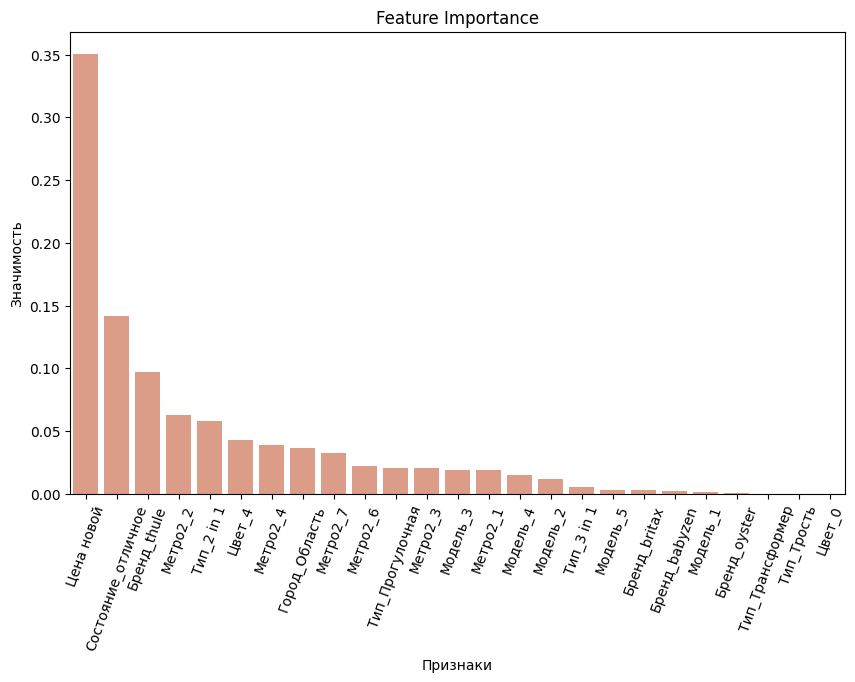

In [809]:
feature_names = X_train.columns
# Получение значений feature importances
importances = rf_best.feature_importances_

# Получение индексов признаков в порядке убывания значимости
indices = np.argsort(importances)[::-1]
# Упорядоченные названия признаков
sorted_feature_names = [feature_names[i] for i in indices]
# Упорядоченные значения feature importances
sorted_importances = importances[indices]

# График feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_names, y=sorted_importances, color='darksalmon')
plt.xticks(rotation=70)
plt.xlabel('Признаки')
plt.ylabel('Значимость')
plt.title('Feature Importance')
plt.show()

 Видим, что Топ-3 по модели случайного леса у нас следующий: огромное значение имеет фактор "Цена новой" и существенное значение имеют факторы "Состояние_отличное" и Бренд_Thule.

 Так же видим, что модели семейства деревьев решений гораздо сильнее склонны к переобучению на наших данных и меньше подходят к ним. Хотя и линейная регрессия не дала хороших результатов, но не показала такого сильного переобучения.

### Таблица

Построим таблицу, в которой отразим все наши модели и метрики

|   **Модель**                    |**Гиперпараметры**                                                  |**R^2 train**|**R^2 test**|
|:--------------------------------|:-------------------------------------------------------------------|:-------------|:----------|
|Линейная регрессия baseline      |                                                                    |     0.27     |   0.26    |
|L1 регуляризация                 | α = 30                                                             |     0.27     |   0.26    |  
|Elastic net                      | α = 0.05, λ =0.6                                                   |     0.27     |   0.27    |  
|Elastic net на полиноме 2 степени| α = 1.56, λ =0.36                                                  |     0.38     |   0.25    |  
|Дерево решений                   | min_samples_leaf': 10, 'max_depth': 5, 'criterion': 'squared_error'|     0.28     |   0.23    |
|Случайный лес                    |'n_est': 180, 'min_s_leaf': 5, 'max_depth': 8, 'crit': 'fr_mse'     |     0.41     |   0.28    |
|Градиентный бустинг              |'n_est': 140, 'min_s_leaf': 9, 'max_depth': 5                       |     0.52     |   0.27    |


# Выводы

После преобразования всех данных о продаже детских колясок на Авито и построения разных моделей видим, что лучший результат показала модель линейной регрессии на эластичной сетке, метрика R^2 на тренировочной и тестовой выборках равна 0.27 и 0.27 соответственно. Однако, ее отличие на тесте от baseline, показавшей на тесте R^2 = 0.26, очень маленькое. 
Модели ансамблей показали переобучение. На градиентном бустинге R^2 был даже больше 0.5 на тренировочных данных, но зависимости модель не уловила, так как тест показал 0.27. А это значит, модель просто лучше подстроилась под train выборку, чем остальные. 
График значимости каждого из факторов показал, что наибольшее влияние на предсказание имеет фактор "Цена новой" и существенное значение имеют факторы "Состояние_отличное" и Бренд_Thule. Но так как коэффициент детерминации сильно ниже 0.5 и очень низкий, то, видимо, те описания данных, которые модели создают, отталкиваясь от этих признаков, вообще не отражают реальность. Ошибка модели простого среднего в таком случае меньше ошибки предсказаний моделей.
Значит, выходит, что, судя по тому, как люди устанавливат цены на свои б/у коляски, и опираясь только на данные Авито, моделям машинного обучения крайне сложно предсказать что-либо. В идеале тут еще не хватает факторов настроения человека: такого аспекта как "жалко/нежалко" (просто лишь бы забрали подешевле или реально заработать), желания продать побыстрее или без спешки (что тоже повлияет на цену) и множества других вещей, которые в теории можно превратить в факторы и добавить в модель. Если все это знать, предсказание могло бы значительно улучшиться, но такие вещи, как правило, в объявлениях не указывают. 